In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime
import ast
import scipy
from math import radians, sin, cos, sqrt, atan2
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

# Data Loading & Understanding & Cleaning

## Order information 

In [2]:
orders = pd.read_csv("all_waybill_info_meituan_0322.csv")
orders.drop(orders.columns[orders.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654343 entries, 0 to 654342
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   dt                          654343 non-null  int64
 1   order_id                    654343 non-null  int64
 2   waybill_id                  654343 non-null  int64
 3   courier_id                  654343 non-null  int64
 4   da_id                       654343 non-null  int64
 5   is_courier_grabbed          654343 non-null  int64
 6   is_weekend                  654343 non-null  int64
 7   estimate_arrived_time       654343 non-null  int64
 8   is_prebook                  654343 non-null  int64
 9   poi_id                      654343 non-null  int64
 10  sender_lng                  654343 non-null  int64
 11  sender_lat                  654343 non-null  int64
 12  recipient_lng               654343 non-null  int64
 13  recipient_lat               654343 non-null 

In [3]:
orders.duplicated().any()

False

In [4]:
orders.isnull().any().any()

False

In [5]:
orders["dt"] =  orders["dt"].map(lambda x: datetime.datetime.strptime(str(x), "%Y%m%d"))
orders["estimate_arrived_time"] =  pd.to_datetime(orders["estimate_arrived_time"], unit='s') + datetime.timedelta(hours=8)
orders["dispatch_time"] =  pd.to_datetime(orders["dispatch_time"], unit='s') + datetime.timedelta(hours=8)
orders["grab_time"] =  pd.to_datetime(orders["grab_time"], unit='s') + datetime.timedelta(hours=8)
orders["fetch_time"] =  pd.to_datetime(orders["fetch_time"], unit='s') + datetime.timedelta(hours=8)
orders["arrive_time"] =  pd.to_datetime(orders["arrive_time"], unit='s') + datetime.timedelta(hours=8)
orders["estimate_meal_prepare_time"] =  pd.to_datetime(orders["estimate_meal_prepare_time"], unit='s') + datetime.timedelta(hours=8)
orders["order_push_time"] =  pd.to_datetime(orders["order_push_time"], unit='s') + datetime.timedelta(hours=8)
orders["platform_order_time"] =  pd.to_datetime(orders["platform_order_time"], unit='s') + datetime.timedelta(hours=8)
orders['day_of_week'] = orders['dt'].dt.day_name()

orders['sender_lat'] = orders['sender_lat'] / 1e6
orders['sender_lng'] = orders['sender_lng'] / 1e6
orders['recipient_lat'] = orders['recipient_lat'] / 1e6
orders['recipient_lng'] = orders['recipient_lng'] / 1e6
orders['grab_lat'] = orders['grab_lat'] / 1e6
orders['grab_lng'] = orders['grab_lng'] / 1e6

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654343 entries, 0 to 654342
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   dt                          654343 non-null  datetime64[ns]
 1   order_id                    654343 non-null  int64         
 2   waybill_id                  654343 non-null  int64         
 3   courier_id                  654343 non-null  int64         
 4   da_id                       654343 non-null  int64         
 5   is_courier_grabbed          654343 non-null  int64         
 6   is_weekend                  654343 non-null  int64         
 7   estimate_arrived_time       654343 non-null  datetime64[ns]
 8   is_prebook                  654343 non-null  int64         
 9   poi_id                      654343 non-null  int64         
 10  sender_lng                  654343 non-null  float64       
 11  sender_lat                  654343 non-

Convert colums into the right form. Add one column "day_of_week"

In [6]:
orders.head()

,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,poi_id,sender_lng,sender_lat,recipient_lng,recipient_lat,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time,day_of_week
0,2022-10-17,0,0,0,0,0,1,2022-10-17 00:32:58,0,0,174.579111,45.862631,174.600135,45.852786,0.000000,0.000000,2022-10-17 00:04:18,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-17 00:12:59,2022-10-17 00:00:00,2022-10-16 23:59:56,Monday
1,2022-10-17,1,1,1,1,1,1,2022-10-17 00:31:04,0,1,174.529930,45.905850,174.522983,45.898250,174.530062,45.906005,2022-10-17 00:12:14,2022-10-17 00:12:17,2022-10-17 00:22:24,2022-10-17 00:29:58,2022-10-17 00:14:05,2022-10-17 00:00:06,2022-10-16 23:59:55,Monday
2,2022-10-17,2,2,2,2,1,0,2022-10-17 00:58:24,0,2,174.532407,45.861460,174.547033,45.891243,174.548244,45.870923,2022-10-17 00:24:44,2022-10-17 00:25:01,2022-10-17 00:39:06,2022-10-17 00:56:24,2022-10-17 00:33:27,2022-10-17 00:18:27,2022-10-17 00:18:17,Monday
3,2022-10-17,3,3,3,0,1,0,2022-10-17 00:57:12,0,3,174.559718,45.868015,174.595327,45.886787,174.560199,45.867948,2022-10-17 00:23:14,2022-10-17 00:23:17,2022-10-17 00:30:30,2022-10-17 01:03:42,2022-10-17 00:27:14,2022-10-17 00:22:49,2022-10-17 00:17:08,Monday
4,2022-10-17,4,4,4,0,1,0,2022-10-17 00:48:14,0,3,174.559718,45.868015,174.534558,45.867411,174.554896,45.865167,2022-10-17 00:23:14,2022-10-17 00:23:33,2022-10-17 00:28:30,2022-10-17 00:37:42,2022-10-17 00:28:14,2022-10-17 00:22:53,2022-10-17 00:18:12,Monday


In [7]:
len(orders[orders["dt"] != orders["platform_order_time"].dt.date])

1858

There is a small portion of the data the dt column and platform_order_time column are not the same date, while they should be. This can be because of system error. <br>
We can remove them

In [8]:
orders = orders[orders["dt"] == orders["platform_order_time"].dt.date]
len(orders)

652485

In [9]:
unsual_orders = orders[((orders["is_courier_grabbed"] == 1) & ((orders["grab_time"] == "1970-01-01 08:00:00") |
                                                             (orders["fetch_time"] == "1970-01-01 08:00:00") |
                                                             (orders["arrive_time"] == "1970-01-01 08:00:00"))) 
                       | 
                       ((orders["is_courier_grabbed"] == 0) & ((orders["grab_time"] != "1970-01-01 08:00:00") |
                                                             (orders["fetch_time"] != "1970-01-01 08:00:00") |
                                                             (orders["arrive_time"] != "1970-01-01 08:00:00"))) 
                       |
                       ((orders["is_courier_grabbed"] == 1) & ((orders["grab_time"] > orders["fetch_time"]) |
                                                              (orders["fetch_time"] > orders["arrive_time"])))]
unsual_orders

,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,poi_id,sender_lng,sender_lat,recipient_lng,recipient_lat,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time,day_of_week
239654,2022-10-18,225004,239654,940,0,1,0,2022-10-18 23:49:00,0,9,174.58027,45.871064,174.546256,45.861818,174.580121,45.869724,2022-10-18 23:10:43,2022-10-18 23:11:52,2022-10-18 23:25:01,1970-01-01 08:00:00,2022-10-18 23:09:00,2022-10-18 23:09:00,2022-10-18 23:08:58,Tuesday


The above order is accepted and taken by the courier, but not delivered, and it's only 1 order, so we can remove it.

In [10]:
orders.drop(unsual_orders.index, inplace=True)
orders.shape

(652484, 24)

In [12]:
orders[orders["is_courier_grabbed"] == 0].shape[0]

85697

Most of the orders are accepted right at the first time. But some orders rejected many times, the maximum rejection time is 16 times before the orders can be accepted.

In [13]:
order_counts = orders.groupby('order_id').size().reset_index(name='repeat_count')
repeated_orders = order_counts[order_counts['repeat_count'] == 17]
repeated_orders_details = orders[orders['order_id'].isin(repeated_orders['order_id'])]
repeated_orders_details

,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,poi_id,sender_lng,sender_lat,recipient_lng,recipient_lat,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time,day_of_week
8448,2022-10-22,8425,8448,2552,5,0,1,2022-10-22 11:36:02,0,178,174.553837,45.898317,174.571978,45.885230,0.000000,0.000000,2022-10-22 10:58:44,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:58,2022-10-22 10:56:58,2022-10-22 10:52:46,Saturday
11714,2022-10-22,11673,11714,391,5,0,1,2022-10-22 11:43:06,0,178,174.553837,45.898317,174.576406,45.886343,0.000000,0.000000,2022-10-22 10:57:14,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:57,2022-10-22 10:56:57,2022-10-22 10:55:26,Saturday
14886,2022-10-22,11673,14886,538,5,0,1,2022-10-22 11:43:06,0,178,174.553837,45.898317,174.576406,45.886343,0.000000,0.000000,2022-10-22 11:02:14,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 10:56:57,2022-10-22 10:56:57,2022-10-22 10:55:26,Saturday
18213,2022-10-22,11673,18213,1462,5,0,1,2022-10-22 11:43:06,0,178,174.553837,45.898317,174.576406,45.886343,0.000000,0.000000,2022-10-22 10:59:14,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:57,2022-10-22 10:56:57,2022-10-22 10:55:26,Saturday
44368,2022-10-22,8425,44368,1462,5,0,1,2022-10-22 11:36:02,0,178,174.553837,45.898317,174.571978,45.885230,0.000000,0.000000,2022-10-22 10:59:14,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:58,2022-10-22 10:56:58,2022-10-22 10:52:46,Saturday
57492,2022-10-22,11673,57492,1351,5,0,1,2022-10-22 11:43:06,0,178,174.553837,45.898317,174.576406,45.886343,0.000000,0.000000,2022-10-22 11:03:44,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 10:56:57,2022-10-22 10:56:57,2022-10-22 10:55:26,Saturday
68128,2022-10-24,66761,68128,550,5,0,0,2022-10-24 11:24:31,0,229,174.554821,45.896190,174.542480,45.896665,0.000000,0.000000,2022-10-24 11:01:20,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-24 10:54:31,2022-10-24 10:54:31,2022-10-24 10:54:29,Monday
106687,2022-10-22,11673,106687,1740,5,0,1,2022-10-22 11:43:06,0,178,174.553837,45.898317,174.576406,45.886343,0.000000,0.000000,2022-10-22 11:00:14,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:57,2022-10-22 10:56:57,2022-10-22 10:55:26,Saturday
113081,2022-10-22,8425,113081,732,5,0,1,2022-10-22 11:36:02,0,178,174.553837,45.898317,174.571978,45.885230,0.000000,0.000000,2022-10-22 11:00:45,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:58,2022-10-22 10:56:58,2022-10-22 10:52:46,Saturday
143142,2022-10-24,66761,143142,2029,5,0,0,2022-10-24 11:24:31,0,229,174.554821,45.896190,174.542480,45.896665,0.000000,0.000000,2022-10-24 10:58:50,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-24 10:54:31,2022-10-24 10:54:31,2022-10-24 10:54:29,Monday


In [14]:
orders[orders["order_id"]==8425]

,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,poi_id,sender_lng,sender_lat,recipient_lng,recipient_lat,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time,day_of_week
8448,2022-10-22,8425,8448,2552,5,0,1,2022-10-22 11:36:02,0,178,174.553837,45.898317,174.571978,45.88523,0.000000,0.000000,2022-10-22 10:58:44,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:58,2022-10-22 10:56:58,2022-10-22 10:52:46,Saturday
44368,2022-10-22,8425,44368,1462,5,0,1,2022-10-22 11:36:02,0,178,174.553837,45.898317,174.571978,45.88523,0.000000,0.000000,2022-10-22 10:59:14,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:58,2022-10-22 10:56:58,2022-10-22 10:52:46,Saturday
113081,2022-10-22,8425,113081,732,5,0,1,2022-10-22 11:36:02,0,178,174.553837,45.898317,174.571978,45.88523,0.000000,0.000000,2022-10-22 11:00:45,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:58,2022-10-22 10:56:58,2022-10-22 10:52:46,Saturday
145522,2022-10-22,8425,145522,2612,5,0,1,2022-10-22 11:36:02,0,178,174.553837,45.898317,174.571978,45.88523,0.000000,0.000000,2022-10-22 11:01:44,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:58,2022-10-22 10:56:58,2022-10-22 10:52:46,Saturday
165245,2022-10-22,8425,165245,391,5,0,1,2022-10-22 11:36:02,0,178,174.553837,45.898317,174.571978,45.88523,0.000000,0.000000,2022-10-22 10:57:14,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:58,2022-10-22 10:56:58,2022-10-22 10:52:46,Saturday
195026,2022-10-22,8425,195026,1740,5,0,1,2022-10-22 11:36:02,0,178,174.553837,45.898317,174.571978,45.88523,0.000000,0.000000,2022-10-22 11:00:14,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:58,2022-10-22 10:56:58,2022-10-22 10:52:46,Saturday
280356,2022-10-22,8425,280356,417,5,0,1,2022-10-22 11:36:02,0,178,174.553837,45.898317,174.571978,45.88523,0.000000,0.000000,2022-10-22 11:04:45,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:58,2022-10-22 10:56:58,2022-10-22 10:52:46,Saturday
316278,2022-10-22,8425,316278,1351,5,0,1,2022-10-22 11:36:02,0,178,174.553837,45.898317,174.571978,45.88523,0.000000,0.000000,2022-10-22 11:03:44,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:58,2022-10-22 10:56:58,2022-10-22 10:52:46,Saturday
322824,2022-10-22,8425,322824,2678,5,0,1,2022-10-22 11:36:02,0,178,174.553837,45.898317,174.571978,45.88523,0.000000,0.000000,2022-10-22 11:03:15,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:58,2022-10-22 10:56:58,2022-10-22 10:52:46,Saturday
342644,2022-10-22,8425,342644,1131,5,0,1,2022-10-22 11:36:02,0,178,174.553837,45.898317,174.571978,45.88523,0.000000,0.000000,2022-10-22 11:02:44,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-22 11:08:58,2022-10-22 10:56:58,2022-10-22 10:52:46,Saturday


In [15]:
default_date = pd.Timestamp('1970-01-01 08:00:00')
orders[orders["order_push_time"] == default_date].shape[0]

0

In [16]:
default_date = pd.Timestamp('1970-01-01 08:00:00')
orders[orders["estimate_meal_prepare_time"] == default_date].shape[0]

9520

There is around 10000 rows do not have estimate_meal_prepare_time. Logically the estimate_meal_prepare_time might affect the decision of courier, so we remove them (10000 is a small portion of the data).

In [17]:
orders = orders[orders["estimate_meal_prepare_time"] != default_date]
orders.shape

(642964, 24)

In [18]:
orders["is_courier_grabbed"].value_counts()

is_courier_grabbed
1    557300
0     85664
Name: count, dtype: int64

## Courier information

In [19]:
couriers = pd.read_csv("courier_wave_info_meituan.csv")
couriers.drop(couriers.columns[couriers.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)

couriers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206748 entries, 0 to 206747
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   dt               206748 non-null  int64 
 1   courier_id       206748 non-null  int64 
 2   wave_id          206748 non-null  int64 
 3   wave_start_time  206748 non-null  int64 
 4   wave_end_time    206748 non-null  int64 
 5   order_ids        206748 non-null  object
dtypes: int64(5), object(1)
memory usage: 9.5+ MB


In [20]:
couriers.duplicated().any()

False

In [21]:
couriers.isnull().any().any()

False

In [22]:
couriers["dt"] =  couriers["dt"].map(lambda x: datetime.datetime.strptime(str(x), "%Y%m%d"))

couriers["wave_start_time"] =  pd.to_datetime(couriers["wave_start_time"], unit='s') + datetime.timedelta(hours=8)
couriers["wave_end_time"] =  pd.to_datetime(couriers["wave_end_time"], unit='s') + datetime.timedelta(hours=8)

couriers['order_ids'] = couriers['order_ids'].apply(ast.literal_eval)

couriers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206748 entries, 0 to 206747
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   dt               206748 non-null  datetime64[ns]
 1   courier_id       206748 non-null  int64         
 2   wave_id          206748 non-null  int64         
 3   wave_start_time  206748 non-null  datetime64[ns]
 4   wave_end_time    206748 non-null  datetime64[ns]
 5   order_ids        206748 non-null  object        
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 9.5+ MB


Convert colums into the right form.

In [23]:
couriers.head()

,dt,courier_id,wave_id,wave_start_time,wave_end_time,order_ids
0,2022-10-17,0,1,2022-10-17 21:59:59,2022-10-17 22:20:27,[171478]
1,2022-10-17,0,2,2022-10-17 23:07:53,2022-10-17 23:33:02,[116902]
2,2022-10-17,1,1,2022-10-17 00:12:17,2022-10-17 00:29:58,[1]
3,2022-10-17,1,2,2022-10-17 11:11:57,2022-10-17 12:07:23,"[264834, 107524, 334962, 125682, 493460]"
4,2022-10-17,2,1,2022-10-17 00:37:57,2022-10-17 01:05:55,"[264776, 2, 398099, 389973]"


In [24]:
orders[orders["is_courier_grabbed"] == 0].head()

,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,poi_id,sender_lng,sender_lat,recipient_lng,recipient_lat,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time,day_of_week
8,2022-10-17,8,8,8,4,0,0,2022-10-17 09:30:00,1,6,174.617410,45.851726,174.621022,45.835245,0.0,0.0,2022-10-17 08:29:15,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-17 02:42:17,2022-10-17 02:28:35,2022-10-17 02:28:19,Monday
25,2022-10-17,25,25,24,12,0,0,2022-10-17 09:20:52,0,22,174.541377,45.885617,174.542315,45.894130,0.0,0.0,2022-10-17 08:51:14,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-17 08:59:53,2022-10-17 08:50:53,2022-10-17 08:50:37,Monday
41,2022-10-17,41,41,39,9,0,0,2022-10-17 11:04:09,0,36,174.595486,45.870933,174.597077,45.890126,0.0,0.0,2022-10-17 10:32:21,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-17 10:41:12,2022-10-17 10:25:12,2022-10-17 10:23:14,Monday
43,2022-10-17,43,43,41,2,0,0,2022-10-17 11:00:35,0,38,174.556338,45.865351,174.544068,45.863370,0.0,0.0,2022-10-17 10:29:15,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-17 10:26:19,2022-10-17 10:26:19,2022-10-17 10:26:02,Monday
63,2022-10-17,63,63,58,1,0,0,2022-10-17 11:37:02,0,58,174.526998,45.905899,174.534806,45.916930,0.0,0.0,2022-10-17 11:09:20,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-17 11:21:03,2022-10-17 11:04:03,2022-10-17 11:03:50,Monday


Check the order 63.

In [25]:
couriers[couriers["order_ids"].apply(lambda x: 63 in x)]

,dt,courier_id,wave_id,wave_start_time,wave_end_time,order_ids
21379,2022-10-17,3363,8,2022-10-17 11:08:24,2022-10-17 11:45:47,"[238924, 318414, 501204, 197815, 149981, 63]"


In [26]:
orders[(orders["order_id"] == 63) | (orders["order_id"] == 238924) | (orders["order_id"] == 318414) | 
       (orders["order_id"] == 501204) | (orders["order_id"] == 197815) | (orders["order_id"] == 149981)]

,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,poi_id,sender_lng,sender_lat,recipient_lng,recipient_lat,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time,day_of_week
63,2022-10-17,63,63,58,1,0,0,2022-10-17 11:37:02,0,58,174.526998,45.905899,174.534806,45.916930,0.000000,0.000000,2022-10-17 11:09:20,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-17 11:21:03,2022-10-17 11:04:03,2022-10-17 11:03:50,Monday
156693,2022-10-17,149981,156693,1534,1,0,0,2022-10-17 11:45:32,0,347,174.531250,45.905800,174.532458,45.928302,0.000000,0.000000,2022-10-17 11:06:49,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-17 11:18:19,2022-10-17 11:06:19,2022-10-17 11:04:22,Monday
156696,2022-10-17,149981,156696,3363,1,1,0,2022-10-17 11:45:32,0,347,174.531250,45.905800,174.532458,45.928302,174.530881,45.905973,2022-10-17 11:08:19,2022-10-17 11:08:24,2022-10-17 11:11:32,2022-10-17 11:39:11,2022-10-17 11:18:19,2022-10-17 11:06:19,2022-10-17 11:04:22,Monday
209272,2022-10-17,197815,209272,3363,1,1,0,2022-10-17 11:43:00,0,627,174.530604,45.905886,174.532677,45.929865,174.530881,45.905973,2022-10-17 11:08:19,2022-10-17 11:08:24,2022-10-17 11:13:19,2022-10-17 11:40:12,2022-10-17 11:16:01,2022-10-17 11:07:01,2022-10-17 11:06:59,Monday
255358,2022-10-17,238924,255358,3363,1,1,0,2022-10-17 12:03:28,0,1090,174.528446,45.906306,174.531756,45.926937,174.531332,45.905848,2022-10-17 11:09:49,2022-10-17 11:09:58,2022-10-17 11:20:42,2022-10-17 11:45:47,2022-10-17 11:22:24,2022-10-17 11:09:24,2022-10-17 11:09:16,Monday
347068,2022-10-17,318414,347068,3363,1,1,0,2022-10-17 11:57:29,0,1090,174.528446,45.906306,174.532463,45.928259,174.531332,45.905848,2022-10-17 11:09:49,2022-10-17 11:09:58,2022-10-17 11:20:40,2022-10-17 11:38:10,2022-10-17 11:22:23,2022-10-17 11:09:23,2022-10-17 11:03:17,Monday
369794,2022-10-17,63,369794,3363,1,1,0,2022-10-17 11:37:02,0,58,174.526998,45.905899,174.534806,45.916930,174.531332,45.905848,2022-10-17 11:10:20,2022-10-17 11:10:25,2022-10-17 11:27:05,2022-10-17 11:33:22,2022-10-17 11:21:03,2022-10-17 11:04:03,2022-10-17 11:03:50,Monday
569000,2022-10-17,501204,569000,3363,1,1,0,2022-10-17 11:45:23,0,2352,174.526537,45.905905,174.531745,45.931092,174.531332,45.905848,2022-10-17 11:09:49,2022-10-17 11:09:57,2022-10-17 11:25:32,2022-10-17 11:41:50,2022-10-17 11:21:24,2022-10-17 11:05:24,2022-10-17 11:05:14,Monday


The courier data only shows the information of accepted data, also the dispatch time (and grab time) for the wave is not the same for all orders. <br>
The wave does not seem to be a batch.

In [27]:
from collections import Counter
all_order_ids = [order_id for sublist in couriers['order_ids'] for order_id in sublist]
order_counts = Counter(all_order_ids)

repeated_orders = {order_id for order_id, count in order_counts.items() if count > 1}

rows_with_repeated_orders = couriers[couriers['order_ids'].apply(lambda ids: any(order_id in repeated_orders for order_id in ids))]

print(rows_with_repeated_orders)

Empty DataFrame
Columns: [dt, courier_id, wave_id, wave_start_time, wave_end_time, order_ids]
Index: []


There is no repeated order in the couriers dataset.

In [28]:
orders_dict_grab = orders.set_index('order_id')['grab_time'].to_dict()
orders_dict_arrive = orders.set_index('order_id')['arrive_time'].to_dict()


default_date = pd.Timestamp('1970-01-01 08:00:00')
couriers['wave_start_time'] = couriers['order_ids'].apply(lambda ids: min(
                        [pd.Timestamp(orders_dict_grab[oid]) for oid in ids 
                         if oid in orders_dict_grab and pd.Timestamp(orders_dict_grab[oid]) != default_date],
                         default=None))
couriers['wave_start_time'] = pd.to_datetime(couriers['wave_start_time'])


couriers['wave_end_time'] = couriers['order_ids'].apply(lambda ids: max(
                        [pd.Timestamp(orders_dict_arrive[oid]) for oid in ids 
                         if oid in orders_dict_arrive and pd.Timestamp(orders_dict_arrive[oid]) != default_date],
                         default=None))
couriers['wave_end_time'] = pd.to_datetime(couriers['wave_end_time'])

couriers.dropna(inplace=True)

couriers["wave_duration"] = couriers["wave_end_time"] - couriers["wave_start_time"]

couriers["wave_size"] = couriers["order_ids"].apply(len)

Cleaning couriers dataframe, rectify the wave_start_time and wave_start_time columns, add wave_duration and wave_size columns

In [29]:
couriers["wave_size"].value_counts().sort_index()

wave_size
1     74519
2     48942
3     27984
4     16086
5      9505
6      6048
7      3997
8      2894
9      2089
10     1610
11     1282
12      957
13      713
14      551
15      429
16      271
17      182
18      144
19      133
20       75
21       59
22       43
23       32
24       15
25       17
26       12
27       13
28       12
29        8
30        3
31        1
32        4
33        1
34        1
35        2
36        1
59        1
Name: count, dtype: int64

In [30]:
couriers[couriers["wave_size"]==59]

,dt,courier_id,wave_id,wave_start_time,wave_end_time,order_ids,wave_duration,wave_size
24448,2022-10-17,4317,2,2022-10-17 12:13:46,2022-10-17 21:33:30,"[403712, 457089, 287750, 29191, 368392, 498698...",0 days 09:19:44,59


There is wave with 59 orders.

In [31]:
orders_dict_dispatch = orders.set_index('order_id')['dispatch_time'].to_dict()


default_date = pd.Timestamp('1970-01-01 08:00:00')
couriers['ealierest_dispatch_time'] = couriers['order_ids'].apply(lambda ids: min(
                        [pd.Timestamp(orders_dict_dispatch[oid]) for oid in ids 
                         if oid in orders_dict_dispatch and pd.Timestamp(orders_dict_dispatch[oid]) != default_date],
                         default=None))
couriers['ealierest_dispatch_time'] = pd.to_datetime(couriers['ealierest_dispatch_time'])


couriers['latest_dispatch_time'] = couriers['order_ids'].apply(lambda ids: max(
                        [pd.Timestamp(orders_dict_dispatch[oid]) for oid in ids 
                         if oid in orders_dict_dispatch and pd.Timestamp(orders_dict_dispatch[oid]) != default_date],
                         default=None))
couriers['latest_dispatch_time'] = pd.to_datetime(couriers['latest_dispatch_time'])

couriers["wave_dispatch_diff"] = couriers['latest_dispatch_time'] - couriers['ealierest_dispatch_time']

Add the ealierest_dispatch_time, latest_dispatch_time (when they are assigned to courier) of the orders in the wave. Calculate wave_dispatch_diff.

In [32]:
couriers.head()

,dt,courier_id,wave_id,wave_start_time,wave_end_time,order_ids,wave_duration,wave_size,ealierest_dispatch_time,latest_dispatch_time,wave_dispatch_diff
0,2022-10-17,0,1,2022-10-17 21:59:59,2022-10-17 22:20:27,[171478],0 days 00:20:28,1,2022-10-17 21:59:45,2022-10-17 21:59:45,0 days 00:00:00
1,2022-10-17,0,2,2022-10-17 23:07:53,2022-10-17 23:33:02,[116902],0 days 00:25:09,1,2022-10-17 23:07:45,2022-10-17 23:07:45,0 days 00:00:00
3,2022-10-17,1,2,2022-10-17 11:11:53,2022-10-17 12:07:23,"[264834, 107524, 334962, 125682, 493460]",0 days 00:55:30,5,2022-10-17 11:11:49,2022-10-17 11:39:49,0 days 00:28:00
4,2022-10-17,2,1,2022-10-17 00:20:49,2022-10-17 01:05:55,"[264776, 2, 398099, 389973]",0 days 00:45:06,4,2022-10-17 00:20:14,2022-10-17 00:37:44,0 days 00:17:30
5,2022-10-17,2,2,2022-10-17 01:12:52,2022-10-17 01:34:24,[119573],0 days 00:21:32,1,2022-10-17 01:12:44,2022-10-17 01:12:44,0 days 00:00:00


In [33]:
couriers[couriers["wave_dispatch_diff"] == couriers["wave_dispatch_diff"].max()]

,dt,courier_id,wave_id,wave_start_time,wave_end_time,order_ids,wave_duration,wave_size,ealierest_dispatch_time,latest_dispatch_time,wave_dispatch_diff
60185,2022-10-19,1129,2,2022-10-19 00:35:19,2022-10-19 02:11:13,"[207334, 352235, 491404, 105301, 26520]",0 days 01:35:54,5,2022-10-19 00:33:13,2022-10-19 11:40:20,0 days 11:07:07


**The highest difference of wave dispatch_time is around 11 hours. So we can conclude that the wave is not the batch. <br>
We try to find batch information in couriers dataset, but we see so far, the wave is not a batch. <br>
Therefore, this dataset is not relevant in terms of affecting the acceptance rate of the couriers (In terms of routing, it may be relevant).**

## Assignment information

In [34]:
dispatch_orders = pd.read_csv("dispatch_waybill_meituan.csv")
dispatch_orders.drop(dispatch_orders.columns[dispatch_orders.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)

dispatch_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15921 entries, 0 to 15920
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   dt             15921 non-null  int64
 1   dispatch_time  15921 non-null  int64
 2   order_id       15921 non-null  int64
dtypes: int64(3)
memory usage: 373.3 KB


In [35]:
dispatch_orders.duplicated().any()

False

In [36]:
dispatch_orders["dt"] =  dispatch_orders["dt"].map(lambda x: datetime.datetime.strptime(str(x), "%Y%m%d"))

dispatch_orders["dispatch_time"] =  pd.to_datetime(dispatch_orders["dispatch_time"], unit='s') + datetime.timedelta(hours=8)

In [37]:
dispatch_orders.head()

,dt,dispatch_time,order_id
0,2022-10-17,2022-10-17 11:25:14,522093
1,2022-10-17,2022-10-17 11:25:14,259146
2,2022-10-17,2022-10-17 11:25:14,64002
3,2022-10-17,2022-10-17 11:25:14,85993
4,2022-10-17,2022-10-17 11:25:14,215713


In [38]:
dispatch_orders.groupby("dispatch_time")["order_id"].count()

dispatch_time
2022-10-17 11:25:14    658
2022-10-17 11:27:14    624
2022-10-17 11:30:14    634
2022-10-18 11:25:06    710
2022-10-18 11:27:06    645
2022-10-18 11:30:06    615
2022-10-19 11:25:13    715
2022-10-19 11:27:13    721
2022-10-19 11:30:13    638
2022-10-20 11:25:12    643
2022-10-20 11:27:12    687
2022-10-20 11:30:12    691
2022-10-21 11:25:07    733
2022-10-21 11:27:07    684
2022-10-21 11:30:07    663
2022-10-22 11:25:10    700
2022-10-22 11:27:10    672
2022-10-22 11:30:10    634
2022-10-23 11:25:19    634
2022-10-23 11:27:19    591
2022-10-23 11:30:19    669
2022-10-24 11:25:17    650
2022-10-24 11:27:17    702
2022-10-24 11:30:17    608
Name: order_id, dtype: int64

**It does not make sense that the dispatch_time only has 3 time points in one day. In the paper, it is explained as the time where the orders enter the assignment procedure. <br>
We do not use this dataset.**

In [39]:
dispatch_couriers = pd.read_csv("dispatch_rider_meituan.csv")
dispatch_couriers.drop(dispatch_couriers.columns[dispatch_couriers.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)

dispatch_couriers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62044 entries, 0 to 62043
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   dt                62044 non-null  int64 
 1   rider_lat         62044 non-null  int64 
 2   rider_lng         62044 non-null  int64 
 3   dispatch_time     62044 non-null  int64 
 4   courier_waybills  62044 non-null  object
 5   courier_id        62044 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 2.8+ MB


In [40]:
dispatch_couriers.duplicated().any()

False

In [41]:
dispatch_couriers["dt"] =  dispatch_couriers["dt"].map(lambda x: datetime.datetime.strptime(str(x), "%Y%m%d"))

dispatch_couriers["dispatch_time"] =  pd.to_datetime(dispatch_orders["dispatch_time"], unit='s') + datetime.timedelta(hours=8)

dispatch_couriers['courier_waybills'] = dispatch_couriers['courier_waybills'].apply(ast.literal_eval)

dispatch_couriers['rider_lat'] = dispatch_couriers['rider_lat'] / 1e6
dispatch_couriers['rider_lng'] = dispatch_couriers['rider_lng'] / 1e6

In [42]:
dispatch_couriers.head()

,dt,rider_lat,rider_lng,dispatch_time,courier_waybills,courier_id
0,2022-10-17,45.852983,174.574564,2022-10-17 19:25:14,"[284829, 227311]",705
1,2022-10-17,45.871077,174.595507,2022-10-17 19:25:14,"[165204, 253364, 73375, 483038, 218555, 218582]",392
2,2022-10-17,45.862480,174.577300,2022-10-17 19:25:14,"[16073, 509042]",3248
3,2022-10-17,45.912267,174.526266,2022-10-17 19:25:14,"[555809, 310156, 54588, 113651, 28934, 440990,...",993
4,2022-10-17,45.857203,174.529566,2022-10-17 19:25:14,"[403600, 128710, 506457]",4183


In [43]:
couriers[couriers["order_ids"].apply(lambda x: 128710 in x)]

,dt,courier_id,wave_id,wave_start_time,wave_end_time,order_ids,wave_duration,wave_size,ealierest_dispatch_time,latest_dispatch_time,wave_dispatch_diff
24068,2022-10-17,4183,2,2022-10-17 11:03:43,2022-10-17 12:27:30,"[45093, 128710, 403600, 107574, 48312, 506457]",0 days 01:23:47,6,2022-10-17 11:03:19,2022-10-17 11:49:49,0 days 00:46:30


In [44]:
dispatch_couriers[dispatch_couriers["courier_waybills"].apply(lambda x: 227311 in x)]

,dt,rider_lat,rider_lng,dispatch_time,courier_waybills,courier_id
0,2022-10-17,45.852983,174.574564,2022-10-17 19:25:14,"[284829, 227311]",705
3020,2022-10-17,45.859293,174.576184,2022-10-18 19:27:06,"[284829, 227311]",705
5603,2022-10-17,45.862148,174.577046,2022-10-19 19:30:13,"[284829, 227311]",705


In [45]:
orders[(orders["order_id"] == 284829) | (orders["order_id"] == 227311)]

,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,poi_id,sender_lng,sender_lat,recipient_lng,recipient_lat,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time,day_of_week
242236,2022-10-17,227311,242236,4481,0,0,0,2022-10-17 11:50:00,1,226,174.566661,45.849548,174.564109,45.860788,0.000000,0.000000,2022-10-17 11:08:19,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-17 11:11:26,2022-10-17 10:57:26,2022-10-17 10:56:37,Monday
265287,2022-10-17,227311,265287,705,0,1,0,2022-10-17 11:50:00,1,226,174.566661,45.849548,174.564109,45.860788,174.564637,45.850798,2022-10-17 11:09:49,2022-10-17 11:09:56,2022-10-17 11:19:56,2022-10-17 11:42:50,2022-10-17 11:11:26,2022-10-17 10:57:26,2022-10-17 10:56:37,Monday
307822,2022-10-17,284829,307822,705,0,1,0,2022-10-17 11:40:00,1,870,174.566798,45.849895,174.577047,45.862162,174.564592,45.850876,2022-10-17 10:55:47,2022-10-17 10:56:21,2022-10-17 11:20:45,2022-10-17 11:32:19,2022-10-17 09:32:17,2022-10-17 09:16:17,2022-10-17 09:16:13,Monday


In [46]:
dispatch_couriers.groupby("dispatch_time")["courier_id"].count()

dispatch_time
2022-10-17 19:25:14    658
2022-10-17 19:27:14    624
2022-10-17 19:30:14    634
2022-10-18 19:25:06    710
2022-10-18 19:27:06    645
2022-10-18 19:30:06    615
2022-10-19 19:25:13    715
2022-10-19 19:27:13    721
2022-10-19 19:30:13    638
2022-10-20 19:25:12    643
2022-10-20 19:27:12    687
2022-10-20 19:30:12    691
2022-10-21 19:25:07    733
2022-10-21 19:27:07    684
2022-10-21 19:30:07    663
2022-10-22 19:25:10    700
2022-10-22 19:27:10    672
2022-10-22 19:30:10    634
2022-10-23 19:25:19    634
2022-10-23 19:27:19    591
2022-10-23 19:30:19    669
2022-10-24 19:25:17    650
2022-10-24 19:27:17    702
2022-10-24 19:30:17    608
Name: courier_id, dtype: int64

**Similarly to dispatch_orders, it does not make sense that the dispatch_time only has 3 time point in one day. In the paper, it is explained as the time where the couriers and the batches of orders enter the assignment procedure. <br>
We do not use this dataset**.

# Feature Engineering

In [47]:
orders["order_id"].nunique()/8

69737.625

In [48]:
orders["courier_id"].nunique()/8

618.125

In [49]:
orders["dispatch_to_meal_ready_duration"] = orders["estimate_meal_prepare_time"] - orders["dispatch_time"]
orders["dispatch_to_meal_ready_duration"] = orders["dispatch_to_meal_ready_duration"].map(lambda x: x.total_seconds())

orders["meal_prepare_duration"] = orders["estimate_meal_prepare_time"] - orders["platform_order_time"]
orders["meal_prepare_duration"] = orders["meal_prepare_duration"].map(lambda x: x.total_seconds())

orders["assigned_to_deadline_duration"] = orders["estimate_arrived_time"] - orders["dispatch_time"]
orders["assigned_to_deadline_duration"] = orders["assigned_to_deadline_duration"].map(lambda x: x.total_seconds())

In [50]:
meal_prepare_stats = orders.groupby('poi_id')['meal_prepare_duration'].agg(['mean', 'var']).reset_index()
meal_prepare_stats.rename(columns={'mean': 'mean_meal_prepare_duration', 'var': 'var_meal_prepare_duration'}, inplace=True)

orders = orders.merge(meal_prepare_stats, on='poi_id', how='left')

In [51]:
print(orders["dispatch_to_meal_ready_duration"].min(), "|", orders["dispatch_to_meal_ready_duration"].mean(), "|", orders["dispatch_to_meal_ready_duration"].max())
print(orders["meal_prepare_duration"].min(), "|", orders["meal_prepare_duration"].mean(), "|", orders["meal_prepare_duration"].max())
print(orders["assigned_to_deadline_duration"].min(), "|", orders["assigned_to_deadline_duration"].mean(), "|", orders["assigned_to_deadline_duration"].max())

-62139.0 | 334.32398703504396 | 2137.0
1.0 | 707.0055757398547 | 33179.0
-14997.0 | 2048.797327688642 | 19252.0


**Compare these 3 attributes of prebook**

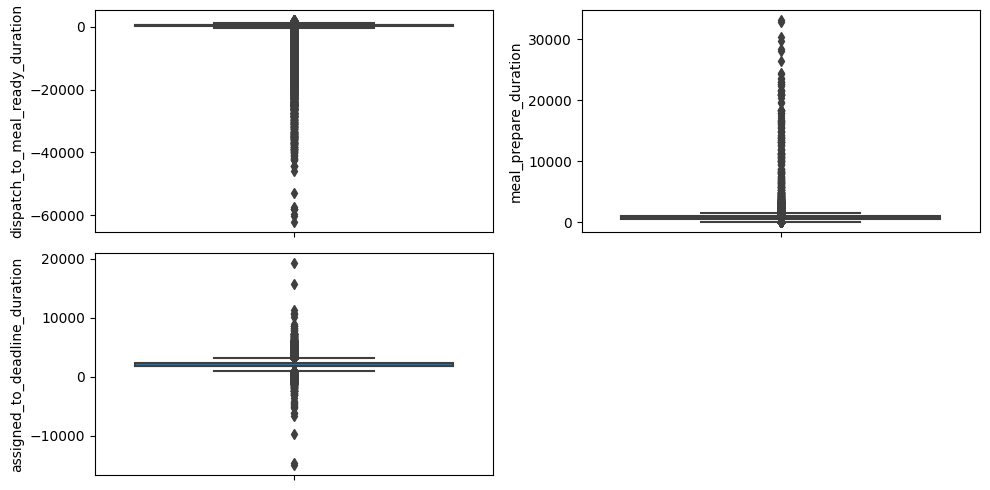

In [52]:
plt.figure(figsize = (10,5))
plt.subplot(2,2,1)
sb.boxplot(data = orders, y = "dispatch_to_meal_ready_duration")
plt.subplot(2,2,2)
sb.boxplot(data = orders, y = "meal_prepare_duration")
plt.subplot(2,2,3)
sb.boxplot(data = orders, y = "assigned_to_deadline_duration")
plt.tight_layout()
plt.show()

We see there are a lot of outliers in this 3 attributes, we need to clean them.

In [53]:
Q1_dispatch_to_meal_ready_duration = np.percentile(orders['dispatch_to_meal_ready_duration'], 25)
Q3_dispatch_to_meal_ready_duration = np.percentile(orders['dispatch_to_meal_ready_duration'], 75)
IQR_dispatch_to_meal_ready_duration = scipy.stats.iqr(orders['dispatch_to_meal_ready_duration'])
lower_o_dispatch_to_meal_ready_duration = orders[orders['dispatch_to_meal_ready_duration'] < (Q1_dispatch_to_meal_ready_duration-1.5*IQR_dispatch_to_meal_ready_duration)].shape[0]
upper_o_dispatch_to_meal_ready_duration = orders[orders['dispatch_to_meal_ready_duration'] > (Q3_dispatch_to_meal_ready_duration+1.5*IQR_dispatch_to_meal_ready_duration)].shape[0]

lower_o_dispatch_to_meal_ready_duration, upper_o_dispatch_to_meal_ready_duration

(63947, 959)

In [54]:
orders = orders[(orders['dispatch_to_meal_ready_duration'] > (Q1_dispatch_to_meal_ready_duration-1.5*IQR_dispatch_to_meal_ready_duration)) & 
                (orders['dispatch_to_meal_ready_duration'] < (Q3_dispatch_to_meal_ready_duration+1.5*IQR_dispatch_to_meal_ready_duration))]

In [55]:
Q1_meal_prepare_duration = np.percentile(orders['meal_prepare_duration'], 25)
Q3_meal_prepare_duration = np.percentile(orders['meal_prepare_duration'], 75)
IQR_meal_prepare_duration = scipy.stats.iqr(orders['meal_prepare_duration'])
lower_o_meal_prepare_duration = orders[orders['meal_prepare_duration'] < (Q1_meal_prepare_duration-1.5*IQR_meal_prepare_duration)].shape[0]
upper_o_meal_prepare_duration = orders[orders['meal_prepare_duration'] > (Q3_meal_prepare_duration+1.5*IQR_meal_prepare_duration)].shape[0]

lower_o_meal_prepare_duration, upper_o_meal_prepare_duration

(46699, 9639)

In [56]:
orders = orders[(orders['meal_prepare_duration'] > (Q1_meal_prepare_duration-1.5*IQR_meal_prepare_duration)) & 
                (orders['meal_prepare_duration'] < (Q3_meal_prepare_duration+1.5*IQR_meal_prepare_duration))]

In [57]:
Q1_assigned_to_deadline_duration = np.percentile(orders['assigned_to_deadline_duration'], 25)
Q3_assigned_to_deadline_duration = np.percentile(orders['assigned_to_deadline_duration'], 75)
IQR_assigned_to_deadline_duration = scipy.stats.iqr(orders['assigned_to_deadline_duration'])
lower_o_assigned_to_deadline_duration = orders[orders['assigned_to_deadline_duration'] < (Q1_assigned_to_deadline_duration-1.5*IQR_assigned_to_deadline_duration)].shape[0]
upper_o_assigned_to_deadline_duration = orders[orders['assigned_to_deadline_duration'] > (Q3_assigned_to_deadline_duration+1.5*IQR_assigned_to_deadline_duration)].shape[0]

lower_o_assigned_to_deadline_duration, upper_o_assigned_to_deadline_duration

(174, 30081)

In [58]:
orders = orders[(orders['assigned_to_deadline_duration'] > (Q1_assigned_to_deadline_duration-1.5*IQR_assigned_to_deadline_duration)) & 
                (orders['assigned_to_deadline_duration'] < (Q3_assigned_to_deadline_duration+1.5*IQR_assigned_to_deadline_duration))]

In [59]:
print(orders[orders["var_meal_prepare_duration"].isnull()]["order_id"].count())
orders = orders[orders["var_meal_prepare_duration"].notnull()]

186


In [60]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0

    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

orders['sender_recipient_distance'] = orders.apply(
    lambda row: haversine(row['sender_lat'], row['sender_lng'], row['recipient_lat'], row['recipient_lng']),
    axis=1
)

In [61]:
pd.crosstab(orders["courier_id"], orders["da_id"])

da_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
courier_id,,,,,,,,,,,,,,,,,,,,,,,
0,21,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,11,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
2,96,0,4,0,3,4,0,0,0,10,0,0,0,4,0,0,0,0,0,0,0,0,0
3,37,0,1,0,12,0,0,0,0,27,0,0,0,2,0,0,0,0,0,0,0,0,0
4,175,0,48,0,0,34,0,0,0,2,0,0,6,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4948,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4950,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [62]:
courier_area_counts = orders.groupby("courier_id")["da_id"].nunique()

orders["courier_area_count"] = orders["courier_id"].map(courier_area_counts)

In [63]:
def find_mode(series):
    modes = series.mode()
    return modes.iloc[0] if not modes.empty else None

courier_main_area = orders.groupby("courier_id")["da_id"].apply(find_mode)

orders["courier_main_area"] = orders["courier_id"].map(courier_main_area)

In [64]:
# Step 1: Compute mean lat/lng for each area
accepted_orders = orders[orders['is_courier_grabbed'] == 1]
area_centroids = accepted_orders.groupby('da_id').agg(
    mean_lat=('sender_lat', 'mean'),
    mean_lng=('sender_lng', 'mean')
).reset_index()

# Step 2: Extract centroid coordinates
centroid_coords = area_centroids[['mean_lat', 'mean_lng']].values

# Step 3: Compute pairwise distances between centroids
def compute_haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth's radius in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def compute_centroid_distance_matrix(coords):
    n = len(coords)
    centroid_distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            lat1, lon1 = coords[i]
            lat2, lon2 = coords[j]
            distance = compute_haversine_distance(lat1, lon1, lat2, lon2)
            centroid_distance_matrix[i, j] = centroid_distance_matrix[j, i] = distance
    
    return centroid_distance_matrix

centroid_distance_matrix = compute_centroid_distance_matrix(centroid_coords)

# Step 4: Create a DataFrame for the centroid distance matrix
area_distance_matrix = pd.DataFrame(
    centroid_distance_matrix,
    index=area_centroids['da_id'],
    columns=area_centroids['da_id']
)

area_distance_matrix

da_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
da_id,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,5.747674,2.007144,5.947912,2.403951,3.344022,35.707391,0.583117,4.368178,4.233881,2.519561,3.565768,3.591904,2.884438,2.868503,2.250552,5.637585,2.797806,10.648670,3.218080,2.317305,5.033178,5.301479
1,5.747674,0.000000,5.430192,0.354820,8.127248,2.581566,35.252100,6.325619,3.663686,7.211242,7.757250,2.361852,2.406566,4.591826,4.481470,3.950538,8.668601,6.857445,16.022365,2.802405,5.314268,9.719897,10.708851
2,2.007144,5.430192,0.000000,5.718760,3.375230,3.689475,37.486203,2.331973,5.406276,6.174413,4.405937,3.073963,3.023626,4.321893,4.261897,1.516114,7.622193,4.793195,10.609029,3.700941,0.333521,4.311725,5.354550
3,5.947912,0.354820,5.718760,0.000000,8.339630,2.705800,34.955096,6.521469,3.578841,7.201178,7.884737,2.644823,2.699495,4.624605,4.517221,4.225701,8.632328,6.923664,16.294472,2.910514,5.614141,10.018600,10.969318
4,2.403951,8.127248,3.375230,8.339630,0.000000,5.746522,36.556171,1.857060,6.562889,5.168400,2.231679,5.871879,5.877827,4.930380,4.952137,4.383417,6.150025,3.646398,8.364048,5.613451,3.687816,3.610245,3.123751
5,3.344022,2.581566,3.689475,2.705800,5.746522,0.000000,34.622349,3.896040,2.072165,4.863476,5.180952,1.440963,1.570203,2.172652,2.057159,2.247289,6.394097,4.311578,13.923403,0.250811,3.719520,7.915542,8.563634
6,35.707391,35.252100,37.486203,34.955096,36.556171,34.622349,0.000000,35.723820,32.550717,31.552096,34.325699,36.027300,36.158276,33.201740,33.276056,36.554325,30.407539,33.095847,42.699518,34.456186,37.700850,40.166341,39.174442
7,0.583117,6.325619,2.331973,6.521469,1.857060,3.896040,35.723820,0.000000,4.780764,4.180084,2.077099,4.147977,4.172705,3.213311,3.215394,2.800989,5.493648,2.665027,10.168863,3.757799,2.660689,4.762855,4.845503
8,4.368178,3.663686,5.406276,3.578841,6.562889,2.072165,32.550717,4.780764,0.000000,3.747983,5.276194,3.495001,3.625915,1.679258,1.632167,4.142786,5.091381,3.902218,14.926162,1.910266,5.515868,9.351868,9.625109


In [65]:
def get_distance(row):
    from_area = row['courier_main_area']
    to_area = row['da_id']
    return area_distance_matrix.at[from_area, to_area]

orders['distance_from_main_area'] = orders.apply(get_distance, axis=1)

orders.head()

,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,poi_id,sender_lng,sender_lat,recipient_lng,recipient_lat,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time,day_of_week,dispatch_to_meal_ready_duration,meal_prepare_duration,assigned_to_deadline_duration,mean_meal_prepare_duration,var_meal_prepare_duration,sender_recipient_distance,courier_area_count,courier_main_area,distance_from_main_area
0,2022-10-17,2,2,2,2,1,0,2022-10-17 00:58:24,0,2,174.532407,45.861460,174.547033,45.891243,174.548244,45.870923,2022-10-17 00:24:44,2022-10-17 00:25:01,2022-10-17 00:39:06,2022-10-17 00:56:24,2022-10-17 00:33:27,2022-10-17 00:18:27,2022-10-17 00:18:17,Monday,523.0,910.0,2020.0,558.982719,153790.296125,3.499931,6,0,2.007144
1,2022-10-17,3,3,3,0,1,0,2022-10-17 00:57:12,0,3,174.559718,45.868015,174.595327,45.886787,174.560199,45.867948,2022-10-17 00:23:14,2022-10-17 00:23:17,2022-10-17 00:30:30,2022-10-17 01:03:42,2022-10-17 00:27:14,2022-10-17 00:22:49,2022-10-17 00:17:08,Monday,240.0,606.0,2038.0,617.607639,1053.433854,3.457740,5,0,0.000000
2,2022-10-17,4,4,4,0,1,0,2022-10-17 00:48:14,0,3,174.559718,45.868015,174.534558,45.867411,174.554896,45.865167,2022-10-17 00:23:14,2022-10-17 00:23:33,2022-10-17 00:28:30,2022-10-17 00:37:42,2022-10-17 00:28:14,2022-10-17 00:22:53,2022-10-17 00:18:12,Monday,300.0,602.0,1500.0,617.607639,1053.433854,1.949220,6,0,0.000000
3,2022-10-17,5,5,5,3,1,0,2022-10-17 01:15:00,0,4,174.542688,45.920329,174.530185,45.921310,174.526338,45.912309,2022-10-17 00:45:27,2022-10-17 00:45:41,2022-10-17 01:07:41,2022-10-17 01:14:56,2022-10-17 00:53:45,2022-10-17 00:40:03,2022-10-17 00:39:59,Monday,498.0,826.0,1773.0,796.773784,34951.556769,0.973276,1,3,0.000000
4,2022-10-17,6,6,6,2,1,0,2022-10-17 02:07:52,0,5,174.557054,45.865154,174.579676,45.878207,174.561783,45.868495,2022-10-17 01:39:14,2022-10-17 01:39:53,2022-10-17 01:42:36,2022-10-17 01:54:19,2022-10-17 01:42:52,2022-10-17 01:37:52,2022-10-17 01:32:46,Monday,218.0,606.0,1718.0,616.362434,755.847276,2.274674,8,0,2.007144


# General Insights

waybill_id
1     402939
2      27030
3       6335
4       1900
5        666
6        274
7        172
8         71
9         23
10        14
11        15
12         9
13         4
14         4
17         1
Name: count, dtype: int64


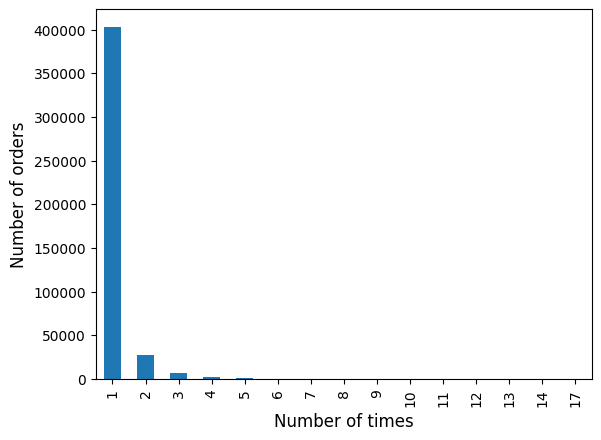

In [66]:
reenter_waybill_count = orders.groupby("order_id")["waybill_id"].nunique().value_counts().sort_index()
print(reenter_waybill_count)
reenter_waybill_count.plot(kind='bar')
plt.xlabel('Number of times', fontsize=12)
plt.ylabel('Number of orders', fontsize=12)
plt.show()

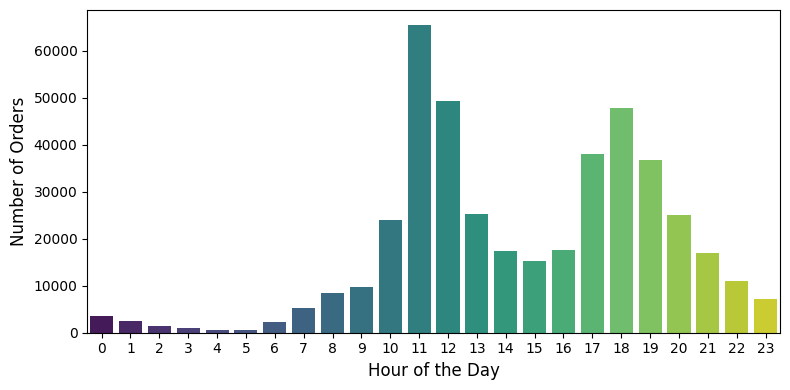

In [67]:
orders['order_hour'] = orders['dispatch_time'].dt.hour
order_distribution = orders[orders["is_courier_grabbed"] == 1].groupby('order_hour').size().reset_index(name='order_count')

plt.figure(figsize=(8, 4))
sb.barplot(data=order_distribution, x='order_hour', y='order_count', palette='viridis')
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

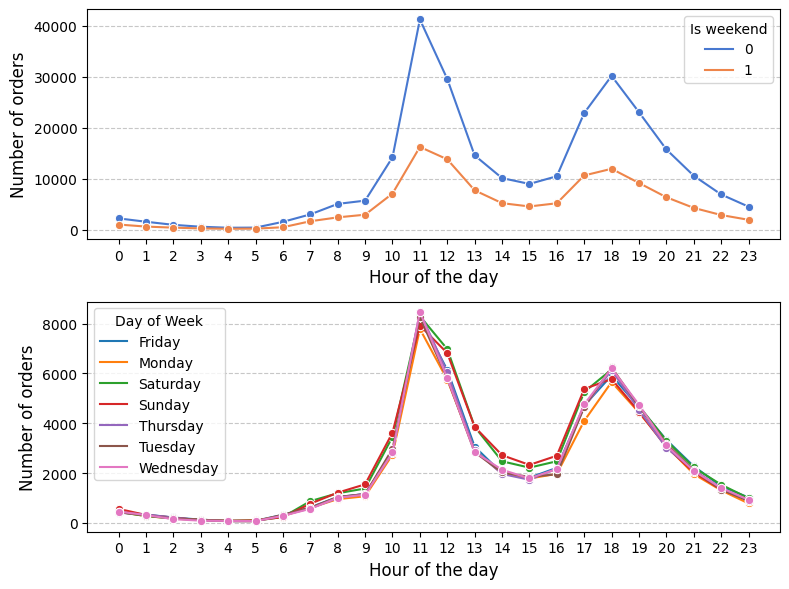

In [68]:
weekend_distribution = orders[(orders["is_courier_grabbed"] == 1) & 
                        (orders["dispatch_time"].dt.date != pd.to_datetime("2022-10-24").date())].groupby(['order_hour', 'is_weekend']).size().reset_index(name='order_count')

plt.figure(figsize=(8, 6))
plt.subplot(2,1,1)
sb.lineplot(data=weekend_distribution, x='order_hour', y='order_count', hue='is_weekend', marker='o', palette='muted')
plt.xlabel('Hour of the day', fontsize=12)
plt.ylabel('Number of orders', fontsize=12)
plt.xticks(range(0, 24))
plt.legend(title='Is weekend')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

daywise_distribution = orders[(orders["is_courier_grabbed"] == 1) & 
                        (orders["dispatch_time"].dt.date != pd.to_datetime("2022-10-24").date())].groupby(['order_hour', 'day_of_week']).size().reset_index(name='order_count')

plt.subplot(2,1,2)
sb.lineplot(data=daywise_distribution, x='order_hour', y='order_count', hue='day_of_week', marker='o', palette='tab10')
plt.xlabel('Hour of the day', fontsize=12)
plt.ylabel('Number of orders', fontsize=12)
plt.xticks(range(0, 24))
plt.legend(title='Day of Week')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Save data for optimization

In [69]:
orders.to_csv("data_for_optimization.csv")

# Feature Selection

In [70]:
def perform_chi_square_test(data, col1, col2):
    contingency_table = pd.crosstab(data[col1], data[col2])

    chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)

    significant = p < 0.01
    return chi2, p, significant

## Batches of orders

As above, we inspect whether wave in couriers dataset can be a batch, and we can conclude that it is not, because the dispatch_time difference (assignment time) of the earliest and latest order in the wave is too far.

We need to investigate how the orders are batched.

In [71]:
orders.groupby(["courier_id","dispatch_time","grab_time"])["order_id"].count().value_counts()

order_id
1    420834
2     30363
3      2941
4       164
5        10
6         1
Name: count, dtype: int64

When groupping together with decisions of couriers

In [72]:
orders.groupby(["courier_id","dispatch_time","grab_time", "is_courier_grabbed"])["order_id"].count().value_counts()

order_id
1    420834
2     30363
3      2941
4       164
5        10
6         1
Name: count, dtype: int64

In [73]:
grouped = orders.groupby(['courier_id', 'dispatch_time', 'grab_time'])

batch_info = grouped.agg(
    batch_size=('order_id', 'count'),  # Count the number of orders
    batched_orders=('order_id', lambda x: list(x))  # Collect order_id into a list
).reset_index()
orders = pd.merge(orders, batch_info, on=['courier_id', 'dispatch_time', 'grab_time'], how='left')

In [74]:
orders.tail()

,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,poi_id,sender_lng,sender_lat,recipient_lng,recipient_lat,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time,day_of_week,dispatch_to_meal_ready_duration,meal_prepare_duration,assigned_to_deadline_duration,mean_meal_prepare_duration,var_meal_prepare_duration,sender_recipient_distance,courier_area_count,courier_main_area,distance_from_main_area,order_hour,batch_size,batched_orders
491090,2022-10-24,57635,654338,1159,0,0,0,2022-10-24 23:16:46,0,578,174.577346,45.863190,174.565865,45.847351,0.000000,0.000000,2022-10-24 22:52:18,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-24 22:57:38,2022-10-24 22:38:38,2022-10-24 22:34:58,Monday,320.0,1360.0,1468.0,1212.665730,206337.232692,1.972929,6,0,0.000000,22,2,"[261986, 57635]"
491091,2022-10-24,568543,654339,1957,0,1,0,2022-10-24 23:27:19,0,574,174.575022,45.868634,174.572847,45.862730,174.576809,45.873238,2022-10-24 22:57:18,2022-10-24 22:57:43,2022-10-24 23:11:27,2022-10-24 23:18:09,2022-10-24 23:09:12,2022-10-24 22:57:16,2022-10-24 22:55:13,Monday,714.0,839.0,1801.0,782.238213,74747.157044,0.677752,5,13,2.884438,22,3,"[143911, 332189, 568543]"
491092,2022-10-24,568544,654340,2323,9,1,0,2022-10-25 00:03:12,0,1250,174.650478,45.879398,174.624534,45.873834,174.624149,45.872077,2022-10-24 23:27:27,2022-10-24 23:27:41,2022-10-24 23:43:47,2022-10-24 23:59:32,2022-10-24 23:32:14,2022-10-24 23:27:07,2022-10-24 23:22:03,Monday,287.0,611.0,2145.0,621.033557,2847.816434,2.101576,6,0,4.233881,23,1,[568544]
491093,2022-10-24,162081,654341,211,12,1,0,2022-10-25 00:20:12,0,285,174.535543,45.889549,174.549855,45.887366,174.537979,45.895683,2022-10-24 23:53:47,2022-10-24 23:54:02,2022-10-25 00:05:38,2022-10-25 00:16:37,2022-10-24 23:59:13,2022-10-24 23:50:13,2022-10-24 23:49:59,Monday,326.0,554.0,1585.0,453.288086,94056.248304,1.134005,7,5,1.570203,23,1,[162081]
491094,2022-10-24,568545,654342,211,12,1,0,2022-10-25 00:28:20,0,113,174.533308,45.887997,174.543784,45.899319,174.534142,45.894631,2022-10-25 00:01:47,2022-10-25 00:02:16,2022-10-25 00:07:39,2022-10-25 00:30:32,2022-10-25 00:06:13,2022-10-24 23:55:13,2022-10-24 23:49:59,Monday,266.0,974.0,1593.0,621.673507,58903.105255,1.497418,7,5,1.570203,0,1,[568545]


In [75]:
orders[orders["order_id"] == 355972]

,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,poi_id,sender_lng,sender_lat,recipient_lng,recipient_lat,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time,day_of_week,dispatch_to_meal_ready_duration,meal_prepare_duration,assigned_to_deadline_duration,mean_meal_prepare_duration,var_meal_prepare_duration,sender_recipient_distance,courier_area_count,courier_main_area,distance_from_main_area,order_hour,batch_size,batched_orders
293518,2022-10-21,355972,391433,1035,0,0,0,2022-10-21 20:45:06,0,2066,174.581152,45.865332,174.578638,45.873672,0.000000,0.000000,2022-10-21 20:17:48,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-21 20:32:09,2022-10-21 20:15:10,2022-10-21 20:14:19,Friday,861.0,1070.0,1638.0,870.554455,191563.757786,0.947573,6,0,0.0,20,1,[355972]
308368,2022-10-21,355972,411249,2402,0,1,0,2022-10-21 20:45:06,0,2066,174.581152,45.865332,174.578638,45.873672,174.582458,45.864119,2022-10-21 20:24:18,2022-10-21 20:24:40,2022-10-21 20:32:02,2022-10-21 20:41:05,2022-10-21 20:32:09,2022-10-21 20:15:10,2022-10-21 20:14:19,Friday,471.0,1070.0,1248.0,870.554455,191563.757786,0.947573,6,0,0.0,20,1,[355972]
310830,2022-10-21,355972,414494,41,0,0,0,2022-10-21 20:45:06,0,2066,174.581152,45.865332,174.578638,45.873672,0.000000,0.000000,2022-10-21 20:20:48,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-21 20:32:09,2022-10-21 20:15:10,2022-10-21 20:14:19,Friday,681.0,1070.0,1458.0,870.554455,191563.757786,0.947573,6,0,0.0,20,1,[355972]
457981,2022-10-21,355972,610408,4951,0,0,0,2022-10-21 20:45:06,0,2066,174.581152,45.865332,174.578638,45.873672,0.000000,0.000000,2022-10-21 20:21:19,1970-01-01 08:00:00,1970-01-01 08:00:00,1970-01-01 08:00:00,2022-10-21 20:32:09,2022-10-21 20:15:10,2022-10-21 20:14:19,Friday,650.0,1070.0,1427.0,870.554455,191563.757786,0.947573,1,0,0.0,20,1,[355972]


In [76]:
default_date = pd.Timestamp("2022-10-17 12:30:12")
orders[orders["grab_time"]==default_date]

,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,poi_id,sender_lng,sender_lat,recipient_lng,recipient_lat,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time,day_of_week,dispatch_to_meal_ready_duration,meal_prepare_duration,assigned_to_deadline_duration,mean_meal_prepare_duration,var_meal_prepare_duration,sender_recipient_distance,courier_area_count,courier_main_area,distance_from_main_area,order_hour,batch_size,batched_orders
95602,2022-10-17,122723,127307,385,11,1,0,2022-10-17 12:59:22,0,2975,174.545729,45.889682,174.539894,45.890087,174.540040,45.890957,2022-10-17 12:29:47,2022-10-17 12:30:12,2022-10-17 12:44:11,2022-10-17 12:48:50,2022-10-17 12:43:05,2022-10-17 12:29:23,2022-10-17 12:29:14,Monday,798.0,831.0,1775.0,801.900000,29337.134783,0.453846,1,11,0.000000,12,1,[122723]
253125,2022-10-17,310229,337460,1311,7,1,0,2022-10-17 12:59:29,0,655,174.578298,45.862248,174.573893,45.858404,174.585437,45.872539,2022-10-17 12:29:53,2022-10-17 12:30:12,2022-10-17 12:51:28,2022-10-17 13:00:47,2022-10-17 12:38:29,2022-10-17 12:29:29,2022-10-17 12:29:27,Monday,516.0,542.0,1776.0,470.514493,15643.050576,0.546860,1,7,0.000000,12,1,[310229]
341352,2022-10-17,409037,455157,3168,5,1,0,2022-10-17 13:12:35,0,572,174.567320,45.892950,174.579108,45.901338,174.568670,45.896290,2022-10-17 12:29:47,2022-10-17 12:30:12,2022-10-17 12:36:03,2022-10-17 12:46:56,2022-10-17 12:36:36,2022-10-17 12:29:43,2022-10-17 12:26:20,Monday,409.0,616.0,2568.0,620.575521,2729.884621,1.304642,6,0,3.344022,12,1,[409037]


The location of the courier of the batch of 3 orders (accepted) at the above grab_time is exactly the same. <br>
So we can conclude that the assumption of the batch is correct.

In [77]:
grouped_counts = orders.groupby(['batch_size', 'is_courier_grabbed']).size()
grabbed_counts = grouped_counts.unstack(fill_value=0)
grabbed_percentage = grabbed_counts.div(grabbed_counts.sum(axis=1), axis=0) * 100
print(grabbed_percentage)

is_courier_grabbed           0          1
batch_size                               
1                     8.554442  91.445558
2                    31.143168  68.856832
3                    39.884393  60.115607
4                    66.463415  33.536585
5                   100.000000   0.000000
6                   100.000000   0.000000


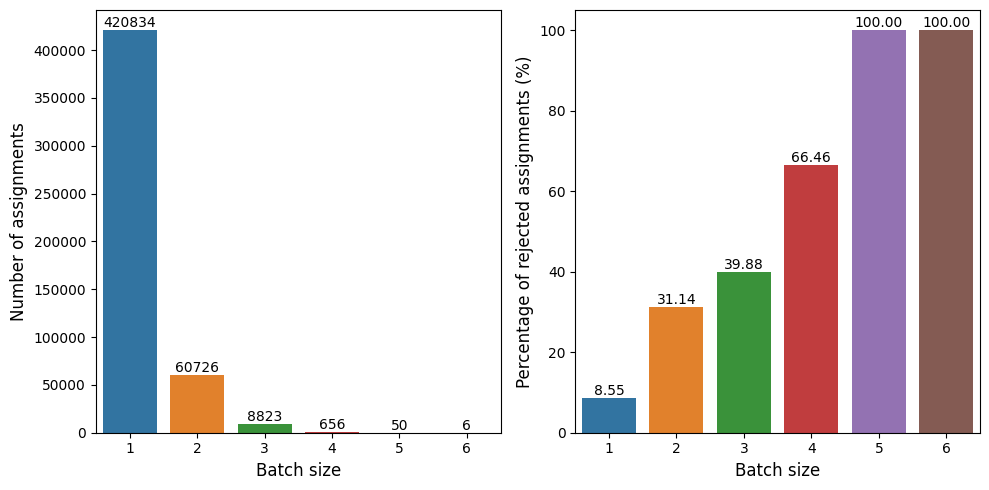

In [78]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
ax = sb.countplot(x='batch_size', data=orders)
ax.bar_label(ax.containers[0])
plt.xlabel('Batch size', fontsize=12)
plt.ylabel('Number of assignments', fontsize=12)
plt.tight_layout()

plt.subplot(1,2,2)
ax2 = sb.barplot(x=grabbed_percentage.index, y=grabbed_percentage[0])
for container in ax2.containers:
    ax2.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues])
plt.xlabel('Batch size', fontsize=12)
plt.ylabel('Percentage of rejected assignments (%)', fontsize=12)
plt.tight_layout()
plt.show()

In [79]:
sampled_orders = orders.sample(n=10000)
chi2, p, significant = perform_chi_square_test(sampled_orders, "is_courier_grabbed", "batch_size")
chi2, p, significant

(674.1055438755036, 8.64545537806711e-146, True)

**We take this as a feature.**

In [80]:
distance_map = orders.set_index('order_id')['sender_recipient_distance'].to_dict()
def calculate_batch_distance(batch):
    return sum(distance_map[order] for order in batch)

orders['batch_distance'] = orders['batched_orders'].apply(calculate_batch_distance)

**From the batch, we can also calculate the distance from restaurants to customers of the whole batch, this seem to affect the decision of courier.**

In [81]:
orders.head()

,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,poi_id,sender_lng,sender_lat,recipient_lng,recipient_lat,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time,day_of_week,dispatch_to_meal_ready_duration,meal_prepare_duration,assigned_to_deadline_duration,mean_meal_prepare_duration,var_meal_prepare_duration,sender_recipient_distance,courier_area_count,courier_main_area,distance_from_main_area,order_hour,batch_size,batched_orders,batch_distance
0,2022-10-17,2,2,2,2,1,0,2022-10-17 00:58:24,0,2,174.532407,45.861460,174.547033,45.891243,174.548244,45.870923,2022-10-17 00:24:44,2022-10-17 00:25:01,2022-10-17 00:39:06,2022-10-17 00:56:24,2022-10-17 00:33:27,2022-10-17 00:18:27,2022-10-17 00:18:17,Monday,523.0,910.0,2020.0,558.982719,153790.296125,3.499931,6,0,2.007144,0,1,[2],3.499931
1,2022-10-17,3,3,3,0,1,0,2022-10-17 00:57:12,0,3,174.559718,45.868015,174.595327,45.886787,174.560199,45.867948,2022-10-17 00:23:14,2022-10-17 00:23:17,2022-10-17 00:30:30,2022-10-17 01:03:42,2022-10-17 00:27:14,2022-10-17 00:22:49,2022-10-17 00:17:08,Monday,240.0,606.0,2038.0,617.607639,1053.433854,3.457740,5,0,0.000000,0,1,[3],3.457740
2,2022-10-17,4,4,4,0,1,0,2022-10-17 00:48:14,0,3,174.559718,45.868015,174.534558,45.867411,174.554896,45.865167,2022-10-17 00:23:14,2022-10-17 00:23:33,2022-10-17 00:28:30,2022-10-17 00:37:42,2022-10-17 00:28:14,2022-10-17 00:22:53,2022-10-17 00:18:12,Monday,300.0,602.0,1500.0,617.607639,1053.433854,1.949220,6,0,0.000000,0,1,[4],1.949220
3,2022-10-17,5,5,5,3,1,0,2022-10-17 01:15:00,0,4,174.542688,45.920329,174.530185,45.921310,174.526338,45.912309,2022-10-17 00:45:27,2022-10-17 00:45:41,2022-10-17 01:07:41,2022-10-17 01:14:56,2022-10-17 00:53:45,2022-10-17 00:40:03,2022-10-17 00:39:59,Monday,498.0,826.0,1773.0,796.773784,34951.556769,0.973276,1,3,0.000000,0,1,[5],0.973276
4,2022-10-17,6,6,6,2,1,0,2022-10-17 02:07:52,0,5,174.557054,45.865154,174.579676,45.878207,174.561783,45.868495,2022-10-17 01:39:14,2022-10-17 01:39:53,2022-10-17 01:42:36,2022-10-17 01:54:19,2022-10-17 01:42:52,2022-10-17 01:37:52,2022-10-17 01:32:46,Monday,218.0,606.0,1718.0,616.362434,755.847276,2.274674,8,0,2.007144,1,1,[6],2.274674


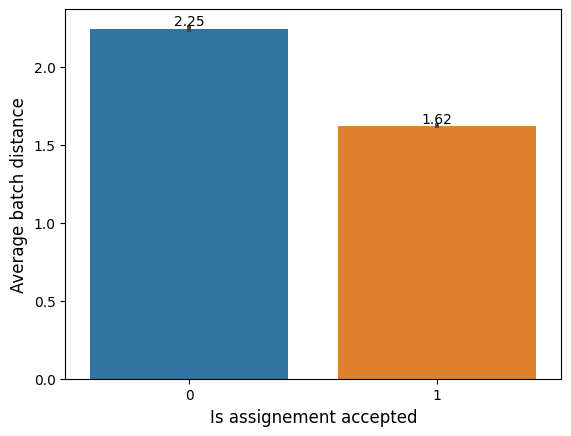

In [82]:
ax = sb.barplot(data=orders, x='is_courier_grabbed', y='batch_distance')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues])
plt.xlabel('Is assignement accepted', fontsize=12)
plt.ylabel('Average batch distance', fontsize=12)
plt.show()

In [83]:
batch_distance_test = orders.groupby('is_courier_grabbed')['batch_distance'].apply(list)
anova_result = stats.f_oneway(*batch_distance_test)
print('P-Value for Anova is: ', anova_result[1])

P-Value for Anova is:  0.0


### Group data by batch

In [84]:
orders = orders.groupby(["courier_id","dispatch_time","grab_time"]).agg({"dt": "first",
                                                                       "order_id": "first",
                                                                       "waybill_id": "first",
                                                                       "da_id": pd.Series.mode,
                                                                       "is_courier_grabbed": "first",
                                                                       "is_weekend": "first",
                                                                       "is_prebook": "first",
                                                                       "dispatch_to_meal_ready_duration": "mean",
                                                                       "meal_prepare_duration": "mean",
                                                                       "mean_meal_prepare_duration": "mean",
                                                                       "var_meal_prepare_duration": "mean",
                                                                       "assigned_to_deadline_duration": "mean",
                                                                       "courier_area_count": "first",
                                                                       "courier_main_area": "first",
                                                                       "distance_from_main_area": "mean",
                                                                       "day_of_week": "first",
                                                                       "batch_size": "first",
                                                                       "batched_orders": "first",
                                                                       "sender_recipient_distance": "first",
                                                                       "batch_distance": "first"})
orders.reset_index(inplace=True)
orders.tail()

,courier_id,dispatch_time,grab_time,dt,order_id,waybill_id,da_id,is_courier_grabbed,is_weekend,is_prebook,dispatch_to_meal_ready_duration,meal_prepare_duration,mean_meal_prepare_duration,var_meal_prepare_duration,assigned_to_deadline_duration,courier_area_count,courier_main_area,distance_from_main_area,day_of_week,batch_size,batched_orders,sender_recipient_distance,batch_distance
454308,4945,2022-10-19 18:35:46,2022-10-19 18:37:14,2022-10-19,407119,622541,0,1,0,0,266.0,670.0,595.621094,111796.480754,1706.0,1,0,0.0,Wednesday,1,[407119],1.191730,1.191730
454309,4948,2022-10-17 12:10:21,1970-01-01 08:00:00,2022-10-17,514373,585517,0,0,0,0,394.0,969.0,903.473770,56786.919672,2493.0,1,0,0.0,Monday,1,[514373],1.892769,1.892769
454310,4950,2022-10-19 20:33:51,2022-10-19 20:34:06,2022-10-19,201762,606186,13,1,0,0,646.0,1027.0,578.255187,190035.062170,1846.0,1,13,0.0,Wednesday,1,[201762],1.664817,1.664817
454311,4951,2022-10-21 20:21:19,1970-01-01 08:00:00,2022-10-21,355972,610408,0,0,0,0,650.0,1070.0,870.554455,191563.757786,1427.0,1,0,0.0,Friday,1,[355972],0.947573,0.947573
454312,4952,2022-10-17 19:49:16,1970-01-01 08:00:00,2022-10-17,411859,618646,2,0,0,0,285.0,612.0,704.265359,151113.762109,1844.0,1,2,0.0,Monday,1,[411859],1.874743,1.874743


In [85]:
# orders["dt"] =  pd.to_datetime(orders["estimate_arrived_time"])
# orders["estimate_arrived_time"] =  pd.to_datetime(orders["estimate_arrived_time"], unit='s')
# orders["dispatch_time"] =  pd.to_datetime(orders["dispatch_time"], unit='s')
# orders["grab_time"] =  pd.to_datetime(orders["grab_time"], unit='s')
# orders["fetch_time"] =  pd.to_datetime(orders["fetch_time"], unit='s')
# orders["arrive_time"] =  pd.to_datetime(orders["arrive_time"], unit='s')
# orders["estimate_meal_prepare_time"] =  pd.to_datetime(orders["estimate_meal_prepare_time"], unit='s')
# orders["order_push_time"] =  pd.to_datetime(orders["order_push_time"], unit='s')
# orders["platform_order_time"] =  pd.to_datetime(orders["platform_order_time"], unit='s')

In [86]:
orders["is_courier_grabbed"].value_counts()

is_courier_grabbed
1    407564
0     46749
Name: count, dtype: int64

In [87]:
orders["da_id"] = orders["da_id"].astype(str)
pd.crosstab(orders["is_courier_grabbed"], orders["da_id"])

da_id,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,3,4,5,6,7,8,9,[ 0 12],[ 5 12],[ 9 13],[0 2],[0 5],[1 5]
is_courier_grabbed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,17421,2412,0,0,2038,2723,0,0,0,0,0,0,4617,0,0,75,0,1844,8978,0,0,0,6616,2,8,1,8,4,2
1,66640,16183,5212,13675,9597,12379,5531,8506,4459,6103,20680,9488,19011,7247,4427,497,21385,11598,34987,39080,34143,16763,39967,0,2,0,1,2,1


In [88]:
orders = orders[~orders["da_id"].isin(["[ 0 12]", "[ 5 12]", "[ 9 13]", "[0 2]", "[0 5]", "[1 5]", "[0 4]"])]
pd.crosstab(orders["is_courier_grabbed"], orders["da_id"])

da_id,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,3,4,5,6,7,8,9
is_courier_grabbed,,,,,,,,,,,,,,,,,,,,,,,
0,17421,2412,0,0,2038,2723,0,0,0,0,0,0,4617,0,0,75,0,1844,8978,0,0,0,6616
1,66640,16183,5212,13675,9597,12379,5531,8506,4459,6103,20680,9488,19011,7247,4427,497,21385,11598,34987,39080,34143,16763,39967


In [89]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 454282 entries, 0 to 454312
Data columns (total 23 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   courier_id                       454282 non-null  int64         
 1   dispatch_time                    454282 non-null  datetime64[ns]
 2   grab_time                        454282 non-null  datetime64[ns]
 3   dt                               454282 non-null  datetime64[ns]
 4   order_id                         454282 non-null  int64         
 5   waybill_id                       454282 non-null  int64         
 6   da_id                            454282 non-null  object        
 7   is_courier_grabbed               454282 non-null  int64         
 8   is_weekend                       454282 non-null  int64         
 9   is_prebook                       454282 non-null  int64         
 10  dispatch_to_meal_ready_duration  454282 non-null 

## Prebooked orders

In [90]:
prebook_count = orders["is_prebook"].value_counts()
prebook_count

is_prebook
0    450303
1      3979
Name: count, dtype: int64

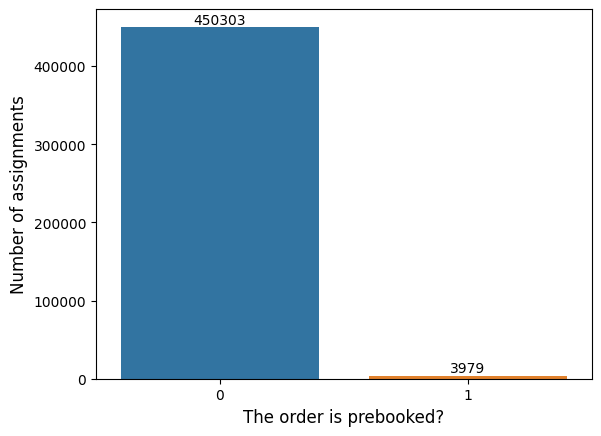

In [91]:
ax = sb.countplot(x='is_prebook', data=orders)
ax.bar_label(ax.containers[0])
plt.xlabel('The order is prebooked?', fontsize=12)
plt.ylabel('Number of assignments', fontsize=12)
plt.show()

The imbalance is too high

**We don't choose this as a feature.**

## Time of day

**Visualize the nnumber of order throughout the day to have more appropriate splitting**

In [92]:
def categorize_time_of_day(dt):
    hour = dt.hour
    
    if 9 <= hour < 13:
        return 2
    elif 13 <= hour < 16:
        return 3
    elif 16 <= hour < 20:
        return 4
    elif 20 <= hour < 24:
        return 5
    else:
        return 1

orders["dispatch_time_of_day"] = orders["dispatch_time"].apply(categorize_time_of_day)
orders["dispatch_time_of_day"].value_counts()

dispatch_time_of_day
2    154352
4    150640
5     64118
3     58614
1     26558
Name: count, dtype: int64

In [93]:
grouped_counts = orders.groupby(['dispatch_time_of_day', 'is_courier_grabbed']).size()
grabbed_counts = grouped_counts.unstack(fill_value=0)
grabbed_percentage = grabbed_counts.div(grabbed_counts.sum(axis=1), axis=0) * 100
grabbed_percentage

is_courier_grabbed,0,1
dispatch_time_of_day,,
1,4.593719,95.406281
2,11.720613,88.279387
3,5.947385,94.052615
4,11.476367,88.523633
5,10.354347,89.645653


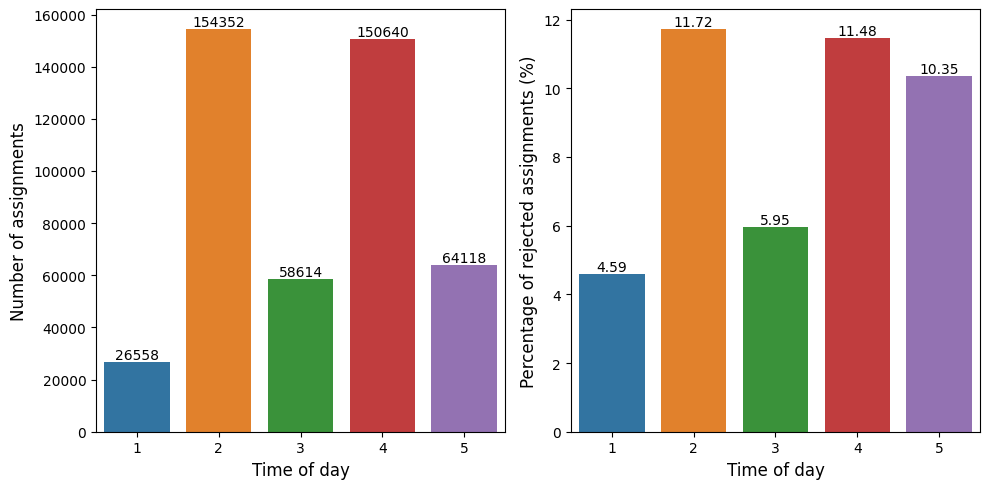

In [94]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
ax = sb.countplot(x='dispatch_time_of_day', data=orders)
ax.bar_label(ax.containers[0])
plt.xlabel('Time of day', fontsize=12)
plt.ylabel('Number of assignments', fontsize=12)
plt.tight_layout()

plt.subplot(1,2,2)
ax2 = sb.barplot(x=grabbed_percentage.index, y=grabbed_percentage[0])
for container in ax2.containers:
    ax2.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues])
plt.xlabel('Time of day', fontsize=12)
plt.ylabel('Percentage of rejected assignments (%)', fontsize=12)
plt.tight_layout()
plt.show()

In [95]:
chi2, p, significant = perform_chi_square_test(orders, "is_courier_grabbed", "dispatch_time_of_day")
chi2, p, significant

(2704.219187570101, 0.0, True)

**We pick this as a feature**

## Weekend & Day of week

In [96]:
grouped_counts = orders.groupby(['is_weekend', 'is_courier_grabbed']).size()
wk_grabbed_counts = grouped_counts.unstack(fill_value=0)
wk_grabbed_percentage = wk_grabbed_counts.div(wk_grabbed_counts.sum(axis=1), axis=0) * 100
wk_grabbed_percentage

is_courier_grabbed,0,1
is_weekend,,
0,10.339774,89.660226
1,10.138947,89.861053


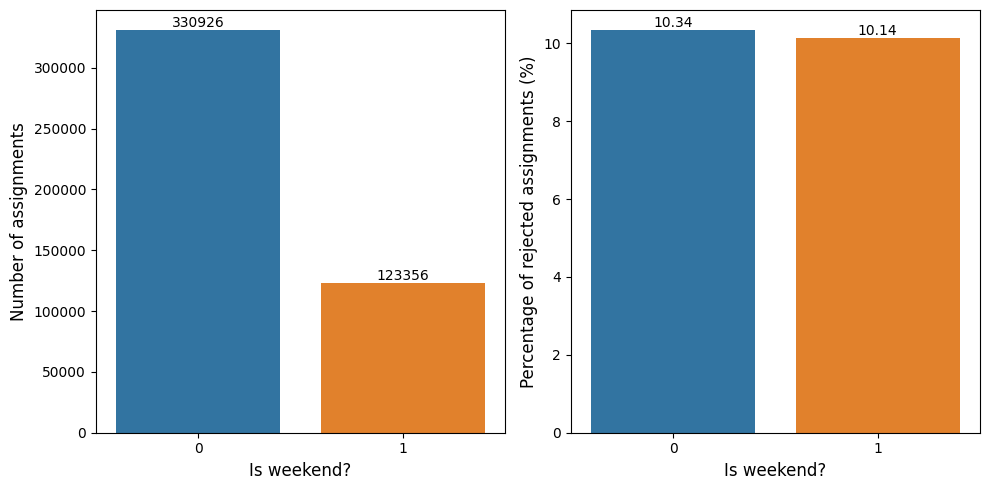

In [97]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
ax = sb.countplot(x='is_weekend', data=orders)
ax.bar_label(ax.containers[0])
plt.xlabel('Is weekend?', fontsize=12)
plt.ylabel('Number of assignments', fontsize=12)
plt.tight_layout()

plt.subplot(1,2,2)
ax2 = sb.barplot(x=wk_grabbed_percentage.index, y=wk_grabbed_percentage[0])
for container in ax2.containers:
    ax2.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues])
plt.xlabel('Is weekend?', fontsize=12)
plt.ylabel('Percentage of rejected assignments (%)', fontsize=12)
plt.tight_layout()
plt.show()

The acceptance rate of is_weekend does not have much diffence.

In [98]:
sampled_orders = orders.sample(n=100000)
chi2, p, significant = perform_chi_square_test(orders, "is_courier_grabbed", "is_weekend")
chi2, p, significant

(3.905880959202549, 0.048117394198453546, False)

In [99]:
grouped_counts = orders.groupby(['day_of_week', 'is_courier_grabbed']).size()
dow_grabbed_counts = grouped_counts.unstack(fill_value=0)
dow_grabbed_percentage = dow_grabbed_counts.div(dow_grabbed_counts.sum(axis=1), axis=0) * 100
dow_grabbed_percentage

is_courier_grabbed,0,1
day_of_week,,
Friday,10.595852,89.404148
Monday,10.296470,89.703530
Saturday,9.914854,90.085146
Sunday,10.363754,89.636246
Thursday,10.192277,89.807723
Tuesday,10.660253,89.339747
Wednesday,9.985619,90.014381


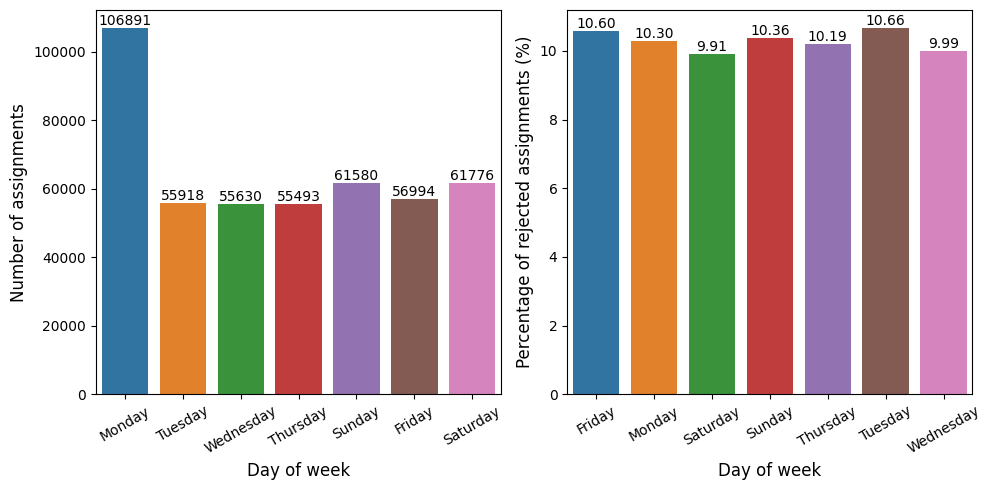

In [100]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
ax = sb.countplot(x='day_of_week', data=orders)
ax.bar_label(ax.containers[0])
plt.xlabel('Day of week', fontsize=12)
plt.ylabel('Number of assignments', fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()

plt.subplot(1,2,2)
ax2 = sb.barplot(x=dow_grabbed_percentage.index, y=dow_grabbed_percentage[0])
for container in ax2.containers:
    ax2.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues])
plt.xlabel('Day of week', fontsize=12)
plt.ylabel('Percentage of rejected assignments (%)', fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [101]:
sampled_orders = orders.sample(n=100000)
chi2, p, significant = perform_chi_square_test(orders, "is_courier_grabbed", "day_of_week")
chi2, p, significant

(30.024015926007834, 3.889734894579455e-05, True)

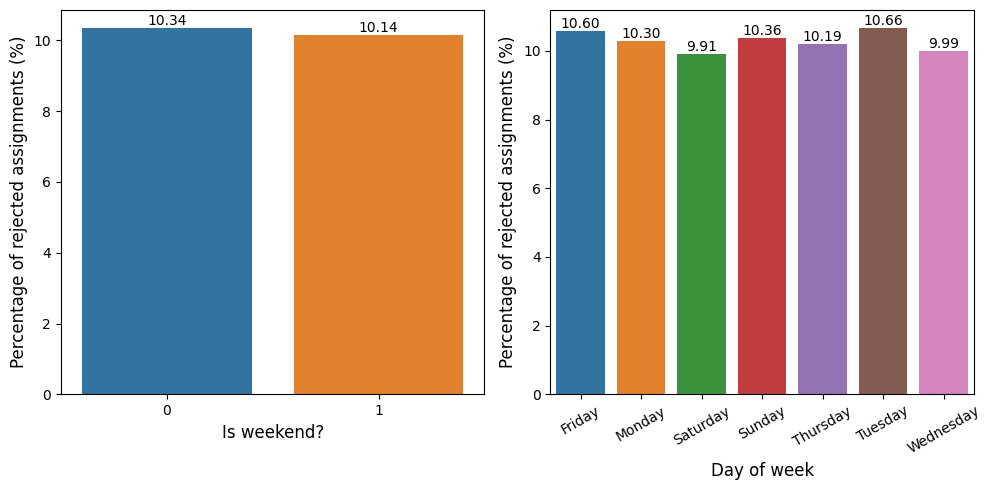

In [102]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
ax = sb.barplot(x=wk_grabbed_percentage.index, y=wk_grabbed_percentage[0])
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues])
plt.xlabel('Is weekend?', fontsize=12)
plt.ylabel('Percentage of rejected assignments (%)', fontsize=12)
plt.tight_layout()

plt.subplot(1,2,2)
ax2 = sb.barplot(x=dow_grabbed_percentage.index, y=dow_grabbed_percentage[0])
for container in ax2.containers:
    ax2.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues])
plt.xlabel('Day of week', fontsize=12)
plt.ylabel('Percentage of rejected assignments (%)', fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Similarly, the acceptance rate of day_of_week does not have much diffence. <br>
We do not need to perform hypothesis testing.

**We do not choose these two attributes as features**

## Pickup availability & Meal preparing time & Overtime risk

In [103]:
# orders["dispatch_to_meal_ready_duration"] = orders["estimate_meal_prepare_time"] - orders["dispatch_time"]
# orders["dispatch_to_meal_ready_duration"] = orders["dispatch_to_meal_ready_duration"].map(lambda x: x.total_seconds())

# orders["meal_prepare_duration"] = orders["estimate_meal_prepare_time"] - orders["platform_order_time"]
# orders["meal_prepare_duration"] = orders["meal_prepare_duration"].map(lambda x: x.total_seconds())

# orders["assigned_to_deadline_duration"] = orders["estimate_arrived_time"] - orders["dispatch_time"]
# orders["assigned_to_deadline_duration"] = orders["assigned_to_deadline_duration"].map(lambda x: x.total_seconds())

Create some columns:
- dispatch_to_meal_ready_duration: the duration from the courier assigned the order to estimated meal ready time (this might affect the courier's decision because the estimated meal ready time is the time the food ready and the courier is able pick it up probably after this time).
- meal_prepare_duration: the duration from the order enter the system to estimated meal ready time (this is calculated by the system, and can affect the courier's decision because it reflex the preparing ability and stability of the restaurant).
- assigned_to_deadline_duration: the duration from the courier assigned the order to estimated delivery time (this might affect the courier's decision because the estimated delivery time reflex overtime risk).

In [104]:
# meal_prepare_stats = orders.groupby('poi_id')['meal_prepare_duration'].agg(['mean', 'var']).reset_index()
# meal_prepare_stats.rename(columns={'mean': 'mean_meal_prepare_duration', 'var': 'var_meal_prepare_duration'}, inplace=True)

# orders = orders.merge(meal_prepare_stats, on='poi_id', how='left')

In [105]:
print(orders["dispatch_to_meal_ready_duration"].min(), "|", orders["dispatch_to_meal_ready_duration"].mean(), "|", orders["dispatch_to_meal_ready_duration"].max())
print(orders["meal_prepare_duration"].min(), "|", orders["meal_prepare_duration"].mean(), "|", orders["meal_prepare_duration"].max())
print(orders["var_meal_prepare_duration"].min(), "|", orders["var_meal_prepare_duration"].mean(), "|", orders["var_meal_prepare_duration"].max())
print(orders["mean_meal_prepare_duration"].min(), "|", orders["mean_meal_prepare_duration"].mean(), "|", orders["mean_meal_prepare_duration"].max())
print(orders["assigned_to_deadline_duration"].min(), "|", orders["assigned_to_deadline_duration"].mean(), "|", orders["assigned_to_deadline_duration"].max())

-337.0 | 592.1601234842383 | 1334.0
108.0 | 803.2160719919931 | 1450.0
0.0 | 127390.62703147806 | 47029009.33333333
14.013452914798206 | 735.981752957835 | 4826.333333333333
1007.0 | 1937.257845273787 | 2949.0


In [106]:
orders[orders["var_meal_prepare_duration"] >= 200000]

,courier_id,dispatch_time,grab_time,dt,order_id,waybill_id,da_id,is_courier_grabbed,is_weekend,is_prebook,dispatch_to_meal_ready_duration,meal_prepare_duration,mean_meal_prepare_duration,var_meal_prepare_duration,assigned_to_deadline_duration,courier_area_count,courier_main_area,distance_from_main_area,day_of_week,batch_size,batched_orders,sender_recipient_distance,batch_distance,dispatch_time_of_day
2,0,2022-10-17 22:45:15,1970-01-01 08:00:00,2022-10-17,64280,65566,0,0,0,0,1007.0,1057.0,596.980769,2.243703e+05,2361.0,3,0,0.000000,Monday,1,[64280],3.477066,3.477066,5
11,0,2022-10-18 23:36:43,2022-10-18 23:36:51,2022-10-18,290987,315038,0,1,0,0,1210.0,1386.0,1272.391304,3.659474e+05,1652.0,3,0,0.000000,Tuesday,1,[290987],0.386309,0.386309,5
16,0,2022-10-20 23:25:13,2022-10-20 23:25:23,2022-10-20,52938,338873,4,1,0,0,702.0,1215.0,963.963855,2.058137e+05,1849.0,3,0,2.403951,Thursday,1,[52938],2.527838,2.527838,5
18,0,2022-10-20 23:30:12,2022-10-20 23:30:33,2022-10-20,145404,151697,0,1,0,0,890.0,1253.0,1212.665730,2.063372e+05,1549.0,3,0,0.000000,Thursday,1,[145404],1.077205,1.077205,5
19,0,2022-10-20 23:30:43,2022-10-20 23:30:52,2022-10-20,515476,586899,0,1,0,0,970.0,1211.0,1212.665730,2.063372e+05,1630.0,3,0,0.000000,Thursday,1,[515476],1.579833,1.579833,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454256,4890,2022-10-24 14:35:48,2022-10-24 14:35:55,2022-10-24,485444,549357,2,1,0,0,398.0,916.0,954.016915,2.298145e+05,1716.0,2,0,2.007144,Monday,1,[485444],1.887799,1.887799,3
454258,4891,2022-10-17 11:14:50,2022-10-17 11:27:02,2022-10-17,250552,608449,5,1,0,0,495.0,1022.0,974.685558,1.061612e+06,1875.0,3,0,3.344022,Monday,1,[250552],1.278431,1.278431,2
454260,4891,2022-10-17 12:00:49,2022-10-17 12:02:53,2022-10-17,19442,396264,2,1,0,0,581.0,1153.0,954.016915,2.298145e+05,2440.0,3,0,2.007144,Monday,1,[19442],1.622704,1.622704,2
454262,4895,2022-10-18 11:33:49,2022-10-18 11:33:59,2022-10-18,86406,510985,2,1,0,0,459.0,1213.0,1107.103896,2.094398e+05,1777.0,2,0,2.007144,Tuesday,1,[86406],1.333849,1.333849,2


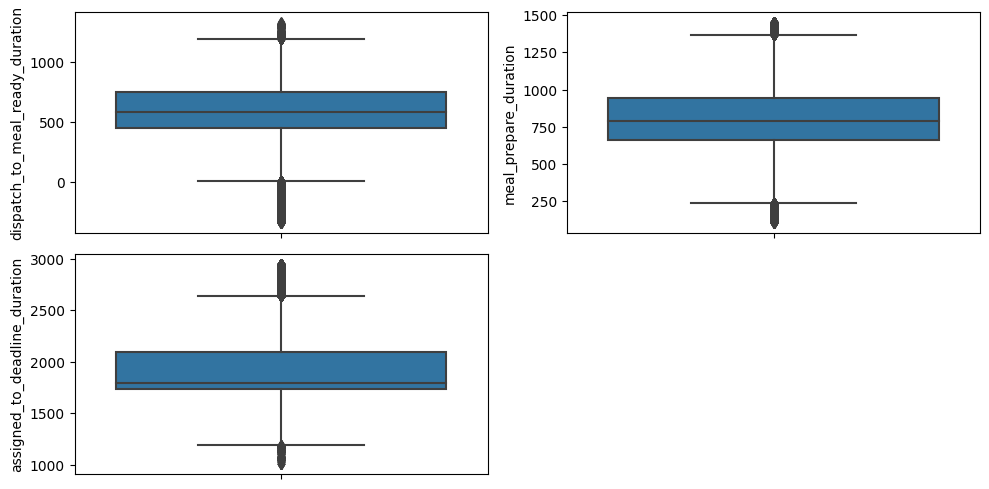

In [107]:
plt.figure(figsize = (10,5))
plt.subplot(2,2,1)
sb.boxplot(data = orders, y = "dispatch_to_meal_ready_duration")
plt.subplot(2,2,2)
sb.boxplot(data = orders, y = "meal_prepare_duration")
plt.subplot(2,2,3)
sb.boxplot(data = orders, y = "assigned_to_deadline_duration")
plt.tight_layout()
plt.show()

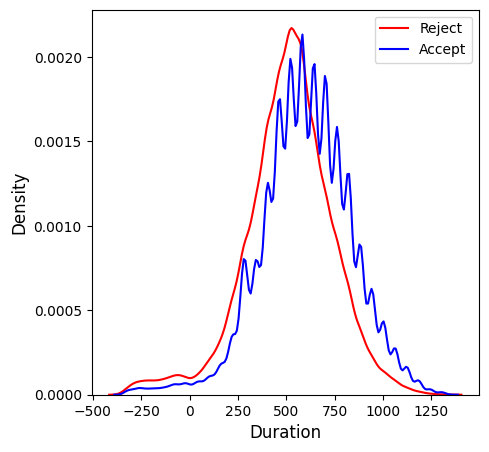

In [108]:
plt.figure(figsize = (5,5))
sb.kdeplot(orders[orders["is_courier_grabbed"] == 0]["dispatch_to_meal_ready_duration"], label="Reject", color="red")
sb.kdeplot(orders[orders["is_courier_grabbed"] == 1]["dispatch_to_meal_ready_duration"], label="Accept", color="blue")
plt.xlabel("Duration", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.show()

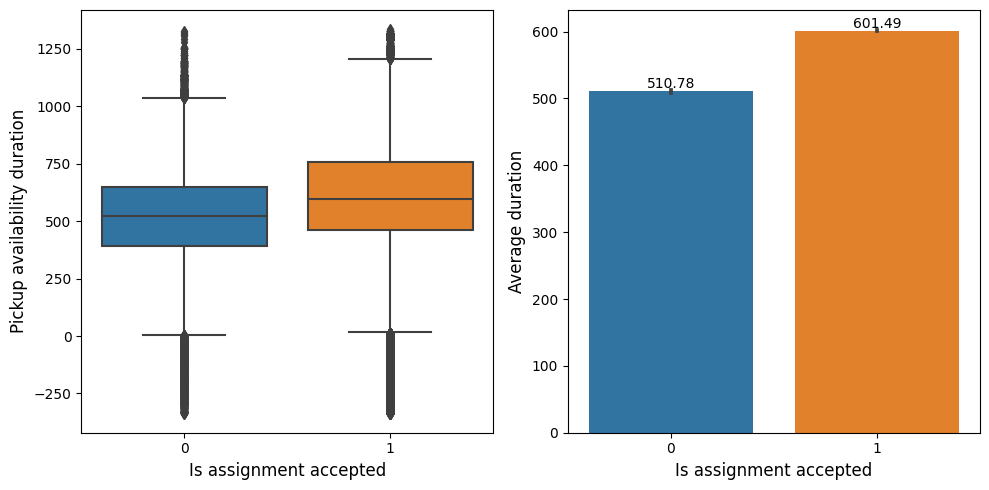

In [109]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
sb.boxplot(data=orders, x="is_courier_grabbed", y="dispatch_to_meal_ready_duration")
plt.xlabel("Is assignment accepted", fontsize=12)  # Set label for x-axis
plt.ylabel("Pickup availability duration", fontsize=12)  # Set label for y-axis
plt.tight_layout()

plt.subplot(1,2,2)
ax2 = sb.barplot(data=orders, x='is_courier_grabbed', y='dispatch_to_meal_ready_duration')
for container in ax2.containers:
    ax2.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues])
plt.xlabel('Is assignment accepted', fontsize=12)
plt.ylabel('Average duration', fontsize=12)
plt.tight_layout()
plt.show()

In [110]:
pickup_availability_test = orders.groupby('is_courier_grabbed')['dispatch_to_meal_ready_duration'].apply(list)
anova_result = stats.f_oneway(*pickup_availability_test)
print('P-Value for Anova is: ', anova_result[1])

P-Value for Anova is:  0.0


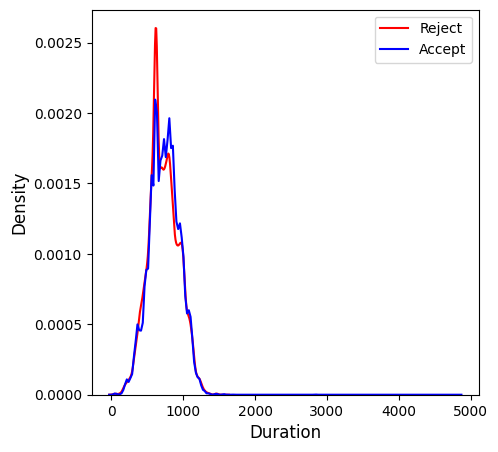

In [111]:
plt.figure(figsize = (5,5))
sb.kdeplot(orders[orders["is_courier_grabbed"] == 0]["mean_meal_prepare_duration"], label="Reject", color="red")
sb.kdeplot(orders[orders["is_courier_grabbed"] == 1]["mean_meal_prepare_duration"], label="Accept", color="blue")
plt.xlabel("Duration", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.show()

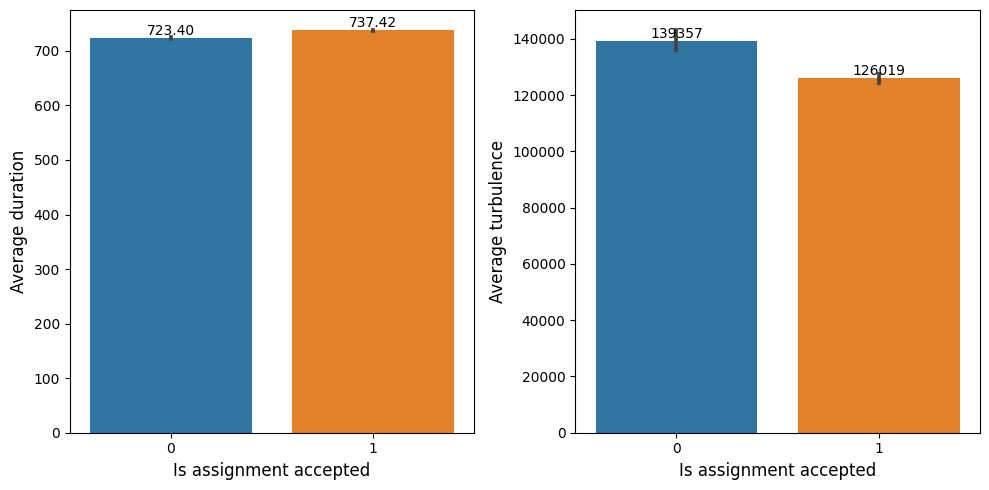

In [112]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
ax = sb.barplot(data=orders, x='is_courier_grabbed', y='mean_meal_prepare_duration')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues])
plt.xlabel('Is assignment accepted', fontsize=12)
plt.ylabel('Average duration', fontsize=12)
plt.tight_layout()

plt.subplot(1,2,2)
ax2 = sb.barplot(data=orders, x='is_courier_grabbed', y='var_meal_prepare_duration')
ax2.bar_label(ax2.containers[0])
plt.xlabel('Is assignment accepted', fontsize=12)
plt.ylabel('Average turbulence', fontsize=12)
plt.tight_layout()
plt.show()

In [113]:
meal_preparing_test = orders.groupby('is_courier_grabbed')['mean_meal_prepare_duration'].apply(list)
anova_result = stats.f_oneway(*pickup_availability_test)
print('P-Value for Anova is: ', anova_result[1])

P-Value for Anova is:  0.0


In [114]:
meal_preparing_test = orders.groupby('is_courier_grabbed')['var_meal_prepare_duration'].apply(list)
anova_result = stats.f_oneway(*pickup_availability_test)
print('P-Value for Anova is: ', anova_result[1])

P-Value for Anova is:  0.0


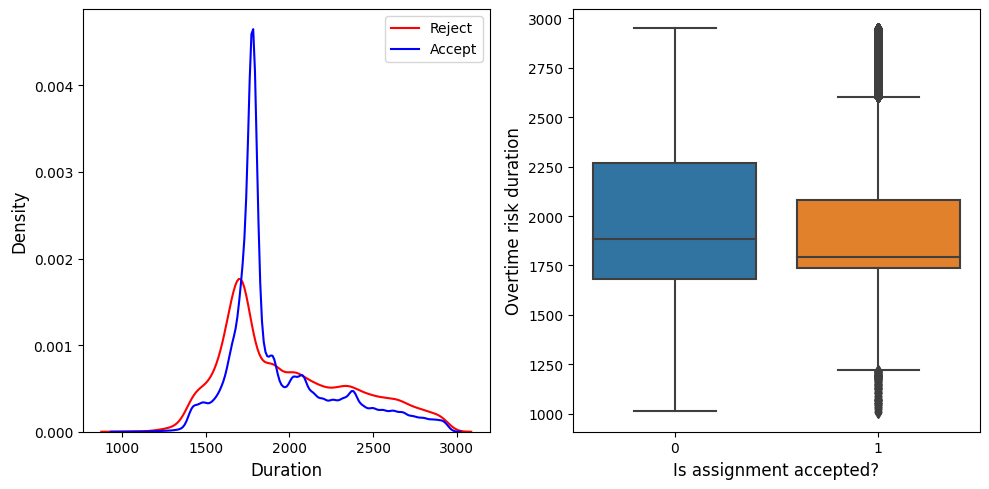

In [115]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
sb.kdeplot(orders[orders["is_courier_grabbed"] == 0]["assigned_to_deadline_duration"], label="Reject", color="red")
sb.kdeplot(orders[orders["is_courier_grabbed"] == 1]["assigned_to_deadline_duration"], label="Accept", color="blue")
plt.xlabel("Duration", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
sb.boxplot(data=orders, x="is_courier_grabbed", y="assigned_to_deadline_duration")
plt.xlabel("Is assignment accepted?", fontsize=12)  # Set label for x-axis
plt.ylabel("Overtime risk duration", fontsize=12)  # Set label for y-axis
plt.tight_layout()
plt.show()

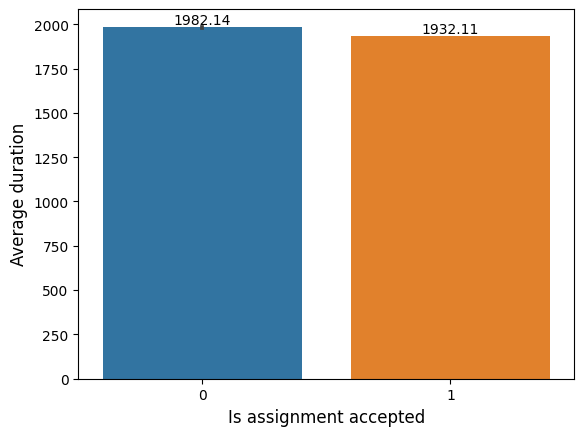

In [116]:
ax = sb.barplot(data=orders, x='is_courier_grabbed', y='assigned_to_deadline_duration')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues])
plt.xlabel('Is assignment accepted', fontsize=12)
plt.ylabel('Average duration', fontsize=12)
plt.show()

In [117]:
orders.shape[0]

454282

In [118]:
overtime_risk_test = orders.groupby('is_courier_grabbed')['assigned_to_deadline_duration'].apply(list)
anova_result = stats.f_oneway(*pickup_availability_test)
print('P-Value for Anova is: ', anova_result[1])

P-Value for Anova is:  0.0


In [119]:
meal_preparing_test = orders.groupby('is_courier_grabbed')['meal_prepare_duration'].apply(list)
anova_result = stats.f_oneway(*pickup_availability_test)
print('P-Value for Anova is: ', anova_result[1])

P-Value for Anova is:  0.0


**We take all these attributes as features.**

## Features extracted from the couriers

In [120]:
# courier_area_counts = orders.groupby("courier_id")["da_id"].nunique()

# orders["courier_area_count"] = orders["courier_id"].map(courier_area_counts)

In [121]:
orders.head()

,courier_id,dispatch_time,grab_time,dt,order_id,waybill_id,da_id,is_courier_grabbed,is_weekend,is_prebook,dispatch_to_meal_ready_duration,meal_prepare_duration,mean_meal_prepare_duration,var_meal_prepare_duration,assigned_to_deadline_duration,courier_area_count,courier_main_area,distance_from_main_area,day_of_week,batch_size,batched_orders,sender_recipient_distance,batch_distance,dispatch_time_of_day
0,0,2022-10-17 00:41:44,1970-01-01 08:00:00,2022-10-17,194804,353538,0,0,0,0,588.0,642.0,557.838710,45122.473118,2236.0,3,0,0.0,Monday,1,[194804],2.853723,2.853723,1
1,0,2022-10-17 22:26:15,1970-01-01 08:00:00,2022-10-17,104853,366839,0,0,0,0,403.0,443.0,548.974274,20986.856763,2439.0,3,0,0.0,Monday,1,[104853],3.153131,3.153131,5
2,0,2022-10-17 22:45:15,1970-01-01 08:00:00,2022-10-17,64280,65566,0,0,0,0,1007.0,1057.0,596.980769,224370.254525,2361.0,3,0,0.0,Monday,1,[64280],3.477066,3.477066,5
3,0,2022-10-17 23:02:15,1970-01-01 08:00:00,2022-10-17,86285,88580,0,0,0,0,369.0,436.0,548.974274,20986.856763,1739.0,3,0,0.0,Monday,1,[86285],1.679459,1.679459,5
4,0,2022-10-17 23:03:14,1970-01-01 08:00:00,2022-10-17,83205,432498,0,0,0,0,645.0,1043.0,903.954198,189228.259425,1728.0,3,0,0.0,Monday,1,[83205],1.722458,1.722458,5


In [122]:
area_courier_count = orders.groupby("courier_id").first()["courier_area_count"]
area_courier_count

courier_id
0       3
1       2
2       6
3       5
4       6
       ..
4945    1
4948    1
4950    1
4951    1
4952    1
Name: courier_area_count, Length: 4900, dtype: int64

In [123]:
orders["courier_area_count"].value_counts()

courier_area_count
1    212608
6     56131
4     46461
5     43737
7     43115
3     27843
2     13317
8     10900
9       170
Name: count, dtype: int64

In [124]:
grouped_counts = orders.groupby(['courier_area_count', 'is_courier_grabbed']).size()
grabbed_counts = grouped_counts.unstack(fill_value=0)
grabbed_percentage = grabbed_counts.div(grabbed_counts.sum(axis=1), axis=0) * 100
print(grabbed_percentage)

is_courier_grabbed          0          1
courier_area_count                      
1                    1.066752  98.933248
2                   19.276113  80.723887
3                   20.766440  79.233560
4                   21.811842  78.188158
5                   19.274299  80.725701
6                   18.642105  81.357895
7                   13.461672  86.538328
8                   11.403670  88.596330
9                   18.823529  81.176471


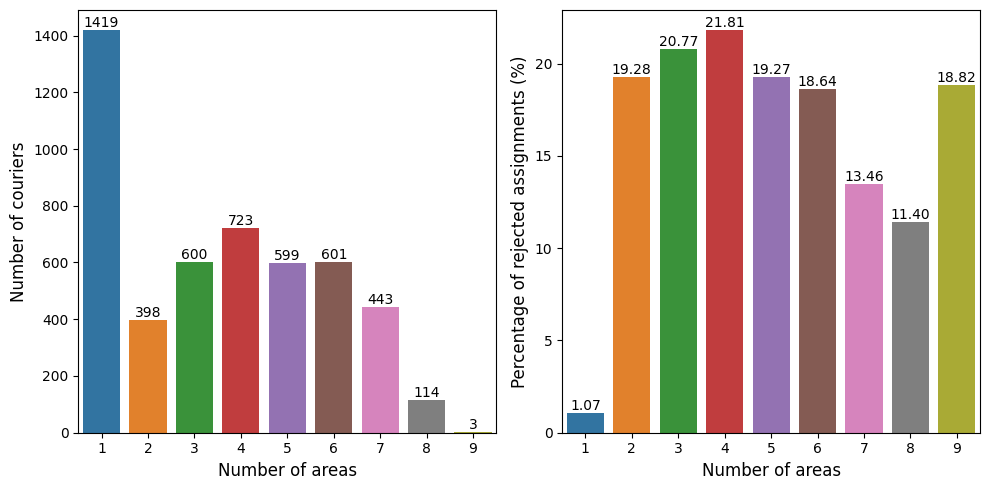

In [125]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
ax = sb.countplot(x=area_courier_count)
ax.bar_label(ax.containers[0])
plt.xlabel('Number of areas', fontsize=12)
plt.ylabel('Number of couriers', fontsize=12)
plt.tight_layout()

plt.subplot(1,2,2)
ax = sb.barplot(x=grabbed_percentage.index, y=grabbed_percentage[0])
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues])
plt.xlabel('Number of areas', fontsize=12)
plt.ylabel('Percentage of rejected assignments (%)', fontsize=12)
plt.tight_layout()
plt.show()

In [126]:
sampled_orders = orders.sample(n=1000)
chi2, p, significant = perform_chi_square_test(orders, "is_courier_grabbed", "courier_area_count")
chi2, p, significant

(39329.51012981319, 0.0, True)

In [127]:
# def find_mode(series):
#     modes = series.mode()
#     return modes.iloc[0] if not modes.empty else None

# courier_main_area = orders.groupby("courier_id")["da_id"].apply(find_mode)

# orders["courier_main_area"] = orders["courier_id"].map(courier_main_area)

In [128]:
orders.head()

,courier_id,dispatch_time,grab_time,dt,order_id,waybill_id,da_id,is_courier_grabbed,is_weekend,is_prebook,dispatch_to_meal_ready_duration,meal_prepare_duration,mean_meal_prepare_duration,var_meal_prepare_duration,assigned_to_deadline_duration,courier_area_count,courier_main_area,distance_from_main_area,day_of_week,batch_size,batched_orders,sender_recipient_distance,batch_distance,dispatch_time_of_day
0,0,2022-10-17 00:41:44,1970-01-01 08:00:00,2022-10-17,194804,353538,0,0,0,0,588.0,642.0,557.838710,45122.473118,2236.0,3,0,0.0,Monday,1,[194804],2.853723,2.853723,1
1,0,2022-10-17 22:26:15,1970-01-01 08:00:00,2022-10-17,104853,366839,0,0,0,0,403.0,443.0,548.974274,20986.856763,2439.0,3,0,0.0,Monday,1,[104853],3.153131,3.153131,5
2,0,2022-10-17 22:45:15,1970-01-01 08:00:00,2022-10-17,64280,65566,0,0,0,0,1007.0,1057.0,596.980769,224370.254525,2361.0,3,0,0.0,Monday,1,[64280],3.477066,3.477066,5
3,0,2022-10-17 23:02:15,1970-01-01 08:00:00,2022-10-17,86285,88580,0,0,0,0,369.0,436.0,548.974274,20986.856763,1739.0,3,0,0.0,Monday,1,[86285],1.679459,1.679459,5
4,0,2022-10-17 23:03:14,1970-01-01 08:00:00,2022-10-17,83205,432498,0,0,0,0,645.0,1043.0,903.954198,189228.259425,1728.0,3,0,0.0,Monday,1,[83205],1.722458,1.722458,5


In [129]:
# poi_area_overlap = orders.groupby('poi_id')['da_id'].nunique().reset_index()

# poi_area_overlap['is_overlapping'] = poi_area_overlap['da_id'] > 1

# poi_area_overlap

In [130]:
# import pandas as pd
# import numpy as np
# from math import radians, sin, cos, sqrt, atan2

# accepted_orders = orders[orders['is_courier_grabbed'] == 1]

# restaurant_locations = accepted_orders.groupby('poi_id').agg(
#     restaurant_lat=('sender_lat', 'first'),
#     restaurant_lng=('sender_lng', 'first')
# ).reset_index()

# area_restaurants = accepted_orders.groupby('da_id')['poi_id'].unique().reset_index()

# def compute_haversine_distance_matrix(coords):
#     n = len(coords)
#     distance_matrix = np.zeros((n, n))

#     for i in range(n):
#         for j in range(i + 1, n):
#             lat1, lon1 = coords[i]
#             lat2, lon2 = coords[j]
#             distance = haversine(lat1, lon1, lat2, lon2)
#             distance_matrix[i][j] = distance_matrix[j][i] = distance  # Symmetric matrix
    
#     return distance_matrix
    
# coords = restaurant_locations[['restaurant_lat', 'restaurant_lng']].values

# distance_matrix_all_restaurants = compute_haversine_distance_matrix(coords)

# def calculate_area_average_distance(area_restaurants, distance_matrix_all_restaurants, restaurant_locations):
#     area_indices = restaurant_locations[restaurant_locations['poi_id'].isin(area_restaurants)].index

#     area_distance_matrix = distance_matrix_all_restaurants[np.ix_(area_indices, area_indices)]
    

#     area_distances = area_distance_matrix[np.triu_indices_from(area_distance_matrix, k=1)]
    
#     return np.mean(area_distances) if len(area_distances) > 0 else 0

# area_distances = []
# for _, row in area_restaurants.iterrows():
#     area_id = row['da_id']
#     area_restaurants_list = row['poi_id']
#     avg_distance = calculate_area_average_distance(area_restaurants_list, distance_matrix_all_restaurants, restaurant_locations)
#     area_distances.append((area_id, avg_distance))


# area_distance_df = pd.DataFrame(area_distances, columns=['da_id', 'average_distance'])

# area_distance_matrix = pd.DataFrame(np.zeros((len(area_distances), len(area_distances))),
#                                      index=[area['da_id'] for _, area in area_restaurants.iterrows()],
#                                      columns=[area['da_id'] for _, area in area_restaurants.iterrows()])

# for i in range(len(area_distances)):
#     for j in range(i, len(area_distances)):
#         distance = np.abs(area_distances[i][1] - area_distances[j][1])
#         area_distance_matrix.iloc[i, j] = distance
#         area_distance_matrix.iloc[j, i] = distance

# area_distance_matrix

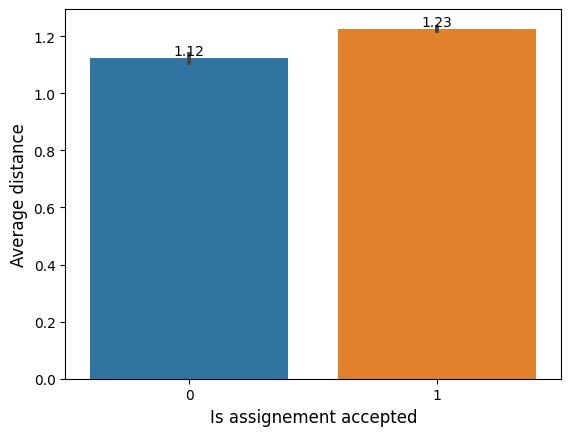

In [131]:
ax = sb.barplot(data=orders[~orders["courier_area_count"].isin([1])], x='is_courier_grabbed', y='distance_from_main_area')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues])
plt.xlabel('Is assignement accepted', fontsize=12)
plt.ylabel('Average distance', fontsize=12)
plt.show()

In [132]:
orders = orders.sort_values(by=['courier_id', 'dispatch_time'])

orders['reject_rate_in_last_hour'] = -1.0

courier_groups = orders.groupby('courier_id')

for courier_id, group in courier_groups:
    
    dispatch_times = group['dispatch_time'].values
    reject_flags = (1 - group['is_courier_grabbed']).values  # 1 for reject, 0 for accept
    
    rolling_window_start = 0
    reject_rates = []
    
    for current_index, current_time in enumerate(dispatch_times):
        
        while dispatch_times[rolling_window_start] < current_time - pd.Timedelta(hours=1):
            rolling_window_start += 1
        
        window_size = current_index - rolling_window_start
        if window_size > 0:
            reject_count = reject_flags[rolling_window_start:current_index].sum()
            reject_rates.append(reject_count / window_size)
        else:
            reject_rates.append(-1)
    
    orders.loc[group.index, 'reject_rate_in_last_hour'] = reject_rates

In [133]:
orders[orders["courier_id"]==0]

,courier_id,dispatch_time,grab_time,dt,order_id,waybill_id,da_id,is_courier_grabbed,is_weekend,is_prebook,dispatch_to_meal_ready_duration,meal_prepare_duration,mean_meal_prepare_duration,var_meal_prepare_duration,assigned_to_deadline_duration,courier_area_count,courier_main_area,distance_from_main_area,day_of_week,batch_size,batched_orders,sender_recipient_distance,batch_distance,dispatch_time_of_day,reject_rate_in_last_hour
0,0,2022-10-17 00:41:44,1970-01-01 08:00:00,2022-10-17,194804,353538,0,0,0,0,588.0,642.0,557.838710,45122.473118,2236.000000,3,0,0.000000,Monday,1,[194804],2.853723,2.853723,1,-1.000000
1,0,2022-10-17 22:26:15,1970-01-01 08:00:00,2022-10-17,104853,366839,0,0,0,0,403.0,443.0,548.974274,20986.856763,2439.000000,3,0,0.000000,Monday,1,[104853],3.153131,3.153131,5,-1.000000
2,0,2022-10-17 22:45:15,1970-01-01 08:00:00,2022-10-17,64280,65566,0,0,0,0,1007.0,1057.0,596.980769,224370.254525,2361.000000,3,0,0.000000,Monday,1,[64280],3.477066,3.477066,5,1.000000
3,0,2022-10-17 23:02:15,1970-01-01 08:00:00,2022-10-17,86285,88580,0,0,0,0,369.0,436.0,548.974274,20986.856763,1739.000000,3,0,0.000000,Monday,1,[86285],1.679459,1.679459,5,1.000000
4,0,2022-10-17 23:03:14,1970-01-01 08:00:00,2022-10-17,83205,432498,0,0,0,0,645.0,1043.0,903.954198,189228.259425,1728.000000,3,0,0.000000,Monday,1,[83205],1.722458,1.722458,5,1.000000
5,0,2022-10-17 23:07:45,2022-10-17 23:07:53,2022-10-17,116902,121074,0,1,0,0,777.0,917.0,894.834667,77112.621494,2397.000000,3,0,0.000000,Monday,1,[116902],3.654248,3.654248,5,1.000000
6,0,2022-10-17 23:32:14,1970-01-01 08:00:00,2022-10-17,543190,621863,2,0,0,0,707.0,790.0,558.982719,153790.296125,1725.000000,3,0,2.007144,Monday,1,[543190],1.242367,1.242367,5,0.750000
7,0,2022-10-17 23:46:44,1970-01-01 08:00:00,2022-10-17,189308,334346,0,0,0,0,609.0,693.0,633.631707,64198.052293,2349.000000,3,0,0.000000,Monday,1,[189308],2.602812,2.602812,5,0.750000
8,0,2022-10-18 22:40:43,2022-10-18 22:40:55,2022-10-18,204351,216528,0,1,0,0,698.0,1105.0,792.635468,164172.876360,1703.000000,3,0,0.000000,Tuesday,1,[204351],1.950810,1.950810,5,-1.000000
9,0,2022-10-18 23:00:13,2022-10-18 23:00:42,2022-10-18,387918,429643,0,1,0,0,836.0,907.0,1013.351788,147626.219059,1796.000000,3,0,0.000000,Tuesday,1,[387918],1.920507,1.920507,5,0.000000


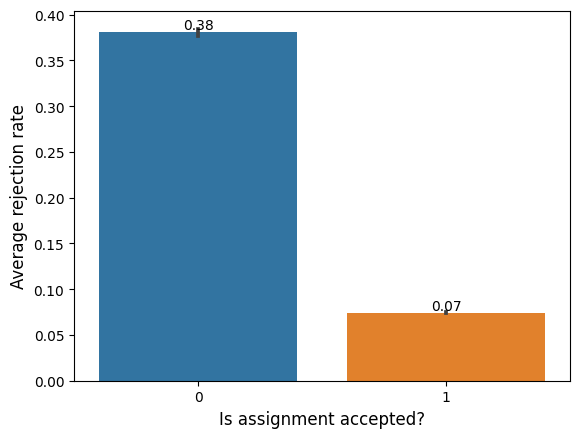

In [134]:
ax = sb.barplot(data=orders[orders["reject_rate_in_last_hour"]!=-1], x='is_courier_grabbed', y='reject_rate_in_last_hour')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues])
plt.xlabel('Is assignment accepted?', fontsize=12)
plt.ylabel('Average rejection rate', fontsize=12)
plt.show()

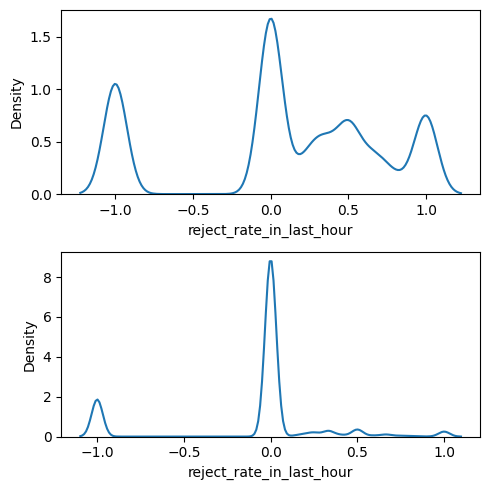

In [135]:
plt.figure(figsize = (5,5))
plt.subplot(2,1,1)
sb.kdeplot(orders[(orders["reject_rate_in_last_hour"]!=-2) & (orders["is_courier_grabbed"]==0)]["reject_rate_in_last_hour"])
plt.subplot(2,1,2)
sb.kdeplot(orders[(orders["reject_rate_in_last_hour"]!=-2) & (orders["is_courier_grabbed"]==1)]["reject_rate_in_last_hour"])
plt.tight_layout()
plt.show()

In [136]:
# orders[(orders["courier_id"] == 0) & (orders["dt"] == pd.Timestamp("2022-10-17"))]

In [137]:
# orders.sort_values(["courier_id", "dispatch_time"], inplace=True)
# orders.head(5)

In [138]:
# orders.shape[0]

In [139]:
# orders['grab_lng'] = orders['grab_lng'].replace(0.0, np.nan)
# orders['grab_lat'] = orders['grab_lat'].replace(0.0, np.nan)

# def get_last_valid_indices(group):
#     last_valid_idx = group['grab_lng'].last_valid_index()
#     if pd.notna(last_valid_idx):
#         return group.loc[:last_valid_idx]
#     else:
#         return group.iloc[:0]

# orders = orders.groupby(['courier_id', 'dt'], group_keys=False).apply(get_last_valid_indices)

# orders['grab_lng'] = orders.groupby(['courier_id', 'dt'])['grab_lng'].bfill()
# orders['grab_lat'] = orders.groupby(['courier_id', 'dt'])['grab_lat'].bfill()

# orders = orders.dropna(subset=['grab_lng', 'grab_lat'])
# orders.head(5)

In [140]:
# orders.shape[0]

In [141]:
# orders['courier_sender_distance'] = orders.apply(
#     lambda row: haversine(row['grab_lat'], row['grab_lng'], row['sender_lat'], row['sender_lng']) 
#     if row['grab_lat'] != 0 and row['grab_lng'] != 0 else None,
#     axis=1
# )

# orders['courier_recipient_distance'] = orders.apply(
#     lambda row: haversine(row['grab_lat'], row['grab_lng'], row['recipient_lat'], row['recipient_lng']) 
#     if row['grab_lat'] != 0 and row['grab_lng'] != 0 else None,
#     axis=1
# )

In [142]:
# orders.head()

# Save preprocessed data

In [143]:
orders.to_csv("preprocessed_data.csv")